In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil
from dateutil.relativedelta import relativedelta
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

## Test 1

#### AEE

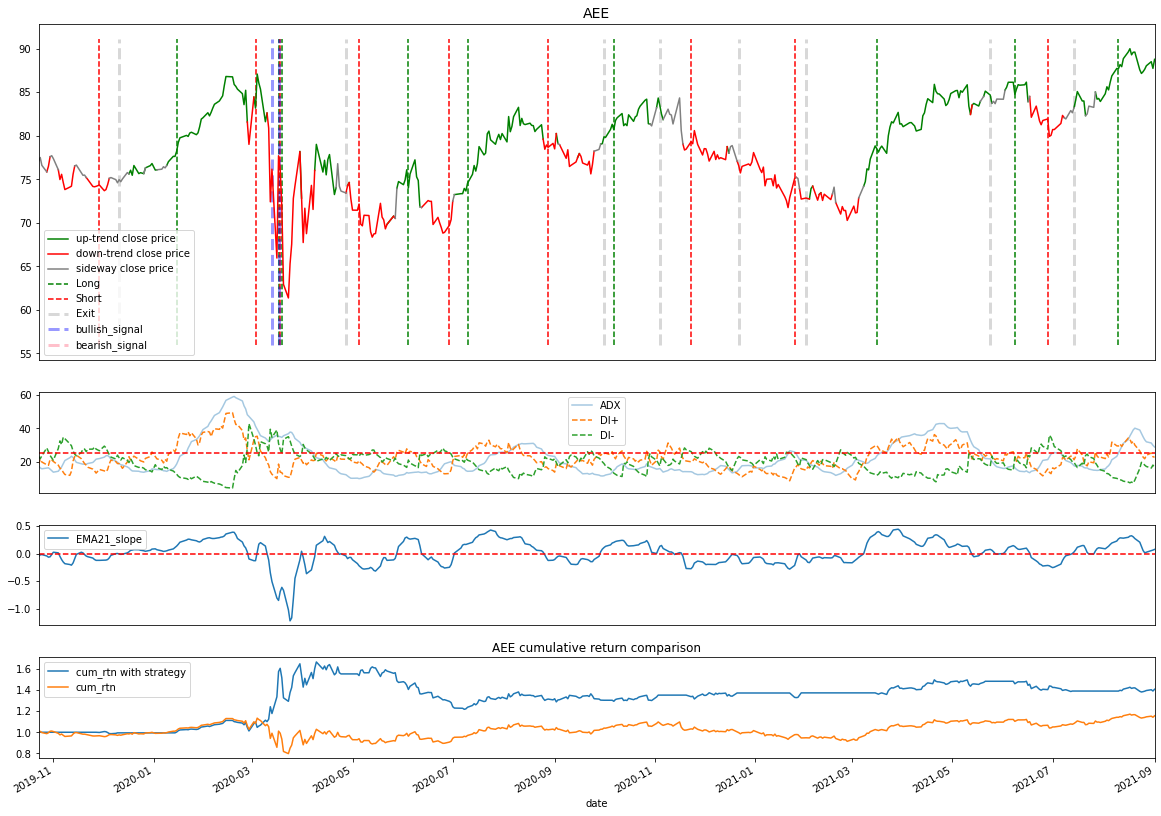

In [2]:
ticker = 'AEE'
# ticker = 'AAPL'
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

today = datetime.today().strftime('%Y-%m-%d')
delta = dateutil.relativedelta.relativedelta(months = int(12 * 2))
begin = (datetime.today() - delta).strftime('%Y-%m-%d')
# today = '2020-05-01'
# begin = '2020-01-01'

stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
{ticker}?from={begin}&to={today}&apikey={fm_key}').json()
stock = pd.DataFrame(stock['historical'])
stock = stock.sort_values('date').reset_index(drop = True)
stock['date'] = pd.to_datetime(stock['date'])
stock['Date'] = stock['date'].apply(mpl_dates.date2num)

def MA(tp, n):
    ma = tp.rolling(window = n).mean()
    return ma

def EMA(close, n):
    ema = close.ewm(span = n).mean()
    return ema

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def Bounds(tp, sma, n, m):
    std = tp.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

def ADX(stock, n = 14):
    
    stock['hl'] = stock['high'] - stock['low']
    stock['hc'] = abs(stock['high'] - stock['close'].shift())
    stock['lc'] = abs(stock['low'] - stock['close'].shift())
    stock['TR'] = stock[['hl', 'hc', 'lc']].max(axis = 1, skipna = False)
    
    temp = sum(stock.TR.isna())
    stock['sm_tr'] = np.nan
    stock.loc[n-1+temp,'sm_tr'] = stock.TR[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'sm_tr'] = stock.loc[i-1,'sm_tr'] - stock.loc[i-1,'sm_tr']/n + stock.loc[i,'TR']
        
    stock['pos_dm'] = np.where((stock.high-stock.high.shift()) > (stock.low.shift()-stock.low),\
                               stock.high-stock.high.shift(), 0)
    stock['neg_dm'] = np.where((stock.high-stock.high.shift()) < (stock.low.shift()-stock.low),\
                              stock.low.shift()-stock.low, 0)
        
    stock['pos_di'] = np.nan
    temp = sum(stock.pos_dm.isna())
    stock.loc[n-1+temp,'pos_di'] = stock.pos_dm[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'pos_di'] = stock.loc[i-1,'pos_di'] - stock.loc[i-1,'pos_di']/n + stock.loc[i,'pos_dm']
    stock.pos_di = (stock.pos_di / stock.sm_tr) * 100
    
    stock['neg_di'] = np.nan
    temp = sum(stock.neg_dm.isna())
    stock.loc[n-1+temp,'neg_di'] = stock.pos_dm[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'neg_di'] = stock.loc[i-1,'neg_di'] - stock.loc[i-1,'neg_di']/n + stock.loc[i,'neg_dm']
    stock.neg_di = (stock.neg_di / stock.sm_tr) * 100
    
    stock['dx'] = (abs(stock.pos_di - stock.neg_di) / abs(stock.pos_di + stock.neg_di)) * 100
    
    temp = sum(stock.dx.isna())
    stock.loc[n-1+temp,'ADX'] = stock.dx[temp:n-1+temp].mean()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'ADX'] = (stock.loc[i-1,'ADX'] * (n-1) + stock.loc[i,'dx']) / n
        
def dragonfly(open, high, low, close):
    if (abs(close - open)/(high - low) < 0.1)\
    & ((min(close, open) - low) > (3 * abs(close - open)))\
    & (high - max(close, open) < abs(close - open)):
        return True
    else:
        return False
    
def gravestone(open, high, low, close):
    if ((abs(close - open) / (high - low) < 0.1)\
        & ((high - max(close, open)) > (3 * abs(close - open)))\
        & ((min(close, open) - low) <= abs(close - open))):
        return True
    else:
        return False
    
def doji(open, high, low, close):
    if (abs(close - open) / (high - low) < 0.1)\
    & ((high - max(close, open)) > (3 * abs(close - open)))\
    & ((min(close, open) - low) > (3 * abs(close - open))):
        return True
    else:
        return False
    

stock['open_ma'] = MA(stock['open'], 3)
stock['close_ma'] = MA(stock['close'], 3)
stock['high_ma'] = MA(stock['high'], 3)
stock['low_ma'] = MA(stock['low'], 3)
stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
stock['EMA21_slope'] = stock['EMA21'].rolling(5).apply(calc_slope)
# stock['EMA44_slope'] = stock['EMA44'].rolling(5).apply(calc_slope)
# stock['EMA21_30_slope'] = stock['EMA21'].rolling(30).apply(calc_slope)

# import talib
# stock['ADX_stand'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)
ADX(stock, n = 14)

stock = stock.dropna()
stock.reset_index(drop = True, inplace = True)

up = []
down = []
sideway = []

if ((stock.loc[0,'pos_di'] > stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] > 0))\
& ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.05)):   
    
    up.append(stock.loc[0,'date'])

elif ((stock.loc[0,'pos_di'] < stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] < 0))\
& ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.05)):

    down.append(stock.loc[0,'date'])

else:
    sideway.append(stock.loc[0,'date'])

for i in range(1, len(stock)):
    if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
    & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.05)):   
        
        if stock.loc[i-1,'date'] not in up:
            up.append(stock.loc[i-1,'date'])
        up.append(stock.loc[i,'date'])
        
    elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
    & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.05)):
        
        if stock.loc[i-1,'date'] not in down:
            down.append(stock.loc[i-1,'date'])
        down.append(stock.loc[i,'date'])
        
    else:
        
        if stock.loc[i-1,'date'] not in sideway:
            sideway.append(stock.loc[i-1,'date'])
        sideway.append(stock.loc[i,'date'])

# for i in range(len(stock)):
#     if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
#     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.1)):   

#         up.append(stock.loc[i,'date'])

#     elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
#     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.1)):

#         down.append(stock.loc[i,'date'])

#     else:
#         sideway.append(stock.loc[i,'date'])

stock['pos'] = np.nan # position for next day
ts = 0 # trading signal
long = [] # long
short = [] # short
exit = []
bullish_signal = []
bearish_signal = []
        
for d in range(7,len(stock)):
    # down-trend
    if stock.loc[d-1,'date'] in down:
        # bullish signal by Fibonacci
        if (stock.loc[d-1,'close'] < stock.loc[d-4,'close'] < stock.loc[d-6,'close'] < stock.loc[d-7,'close']):
            # fib_bull.append(stock.loc[d,'date']) # signal recognized
            # fibonacci bullish signal confirmation
            if (stock.loc[d,'close'] > stock.loc[d-1,'close']):
                
                #if doji(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']):
                if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
                | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
                | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
                #if (stock.loc[d,'open_ma'] == stock.loc[d,'close_ma'])\
                #& (stock.loc[d,'close_ma'] < stock.loc[d-1,'close_ma'] < stock.loc[d-2,'close_ma']):
                    bullish_signal.append(stock.loc[d,'date']) # signal confirmed
                    if (ts != 1):
                        long.append(stock.loc[d+2,'date'])
                        ts = 1

            # bullish signal invalid, still bearish
            elif (stock.loc[d,'close'] < stock.loc[d-1,'close']):
                if (ts != -1):
                    short.append(stock.loc[d+2,'date'])
                    ts = -1

                    
    # up-trend
    elif stock.loc[d-1,'date'] in up:
        # bearish signal by Fibonacci
        if (stock.loc[d-1,'close'] > stock.loc[d-4,'close'] > stock.loc[d-6,'close'] > stock.loc[d-7,'close']):
            #fib_bear.append(stock.loc[d,'date']) #signal recognized
            # bearish signal confirmation
            if (stock.loc[d,'close'] < stock.loc[d-1,'close']):
                
                #if doji(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']):
                #if (gravestone(stock.loc[d,'open_ma'], stock.loc[d,'high_ma'], stock.loc[d,'low_ma'], stock.loc[d,'close_ma']))\
                #| gravestone(stock.loc[d-1,'open_ma'], stock.loc[d-1,'high_ma'], stock.loc[d-1,'low_ma'], stock.loc[d-1,'close_ma'])\
                #| gravestone(stock.loc[d-2,'open_ma'], stock.loc[d-2,'high_ma'], stock.loc[d-2,'low_ma'], stock.loc[d-2,'close_ma']):
                if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
                | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
                | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
                #if (stock.loc[d,'open_ma'] == stock.loc[d,'close_ma'])\
                #& (stock.loc[d,'close_ma'] > stock.loc[d-1,'close_ma'] > stock.loc[d-2,'close_ma']):
                    bearish_signal.append(stock.loc[d,'date']) #signal confirmed
                    if (ts != -1):
                        short.append(stock.loc[d+2,'date'])
                        ts = -1

            # bearish signal invalide, still bullish
            elif (stock.loc[d,'close'] > stock.loc[d-1,'close']):
                if (ts != 1):
                    long.append(stock.loc[d+2,'date'])
                    ts = 1

    
    #stock.loc[d+2,'pos'] = ts
    
    elif stock.loc[d-1,'date'] in sideway:
        if (ts != 0):
            exit.append(stock.loc[d+2,'date'])
            ts = 0
            
    stock.loc[d+2,'pos'] = ts


stock = stock.set_index('date')

# stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
stock['rtn_s'] = stock['close'].pct_change() * stock['pos']
stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

stock['rtn'] = stock['close'].pct_change()
stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

stock = stock.dropna()
        
stock['up_close'] = np.where(stock.index.isin(up), stock.close, np.nan)
stock['down_close'] = np.where(stock.index.isin(down), stock.close, np.nan)
stock['sideway_close'] = np.where(stock.index.isin(sideway), stock.close, np.nan)

plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.xmargin'] = 0
fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 3, 3, 3]})

# data_plot = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]
# candlestick_ohlc(axs[0], data_plot.values, width = 0.6,\
#                  colorup = 'green', colordown = 'red', alpha=0.8)

stock['up_close'].plot(label = 'up-trend close price', ax = axs[0], color = 'green')
stock['down_close'].plot(label = 'down-trend close price', ax = axs[0], color = 'red')
stock['sideway_close'].plot(label = 'sideway close price', ax = axs[0], color = 'grey')
# stock['close'].plot(label = 'Close price', ax = axs[0], color = 'skyblue', alpha = 0.5)
# stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
# stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), max(stock.EMA21))

axs[0].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 1)
axs[0].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 1)
axs[0].vlines(exit, ymin = ymin, ymax = ymax,\
              color = 'grey', linestyle = '--', label = 'Exit', alpha = 0.3, lw = 3)

axs[0].vlines(bullish_signal, ymin = ymin, ymax = ymax,\
              color = 'blue', linestyle = '--', label = 'bullish_signal', alpha = 0.4, lw = 3)
axs[0].vlines(bearish_signal, ymin = ymin, ymax = ymax,\
              color = 'pink', linestyle = '--', label = 'bearish_signal', alpha = 1, lw = 3)

stock['ADX'].plot(label = 'ADX', alpha = 0.4, ax = axs[1])
stock['pos_di'].plot(label = 'DI+', linestyle = '--', ax = axs[1])
stock['neg_di'].plot(label = 'DI-', linestyle = '--', ax = axs[1])
axs[1].axhline(25, color = 'red', linestyle = '--')  

stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
# stock['EMA21_30_slope'].plot(label = 'EMA21_30_slope', ax = axs[2])
# stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
axs[2].axhline(0, color = 'red', linestyle = '--')

stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])

axs[0].set(xlabel = '')
axs[1].set(xlabel = '')
axs[2].set(xlabel = '')
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[0].set_title(f'{ticker}', fontsize = 14)
axs[3].set_title(f'{ticker} cumulative return comparison')

plt.show()

#### AAPL

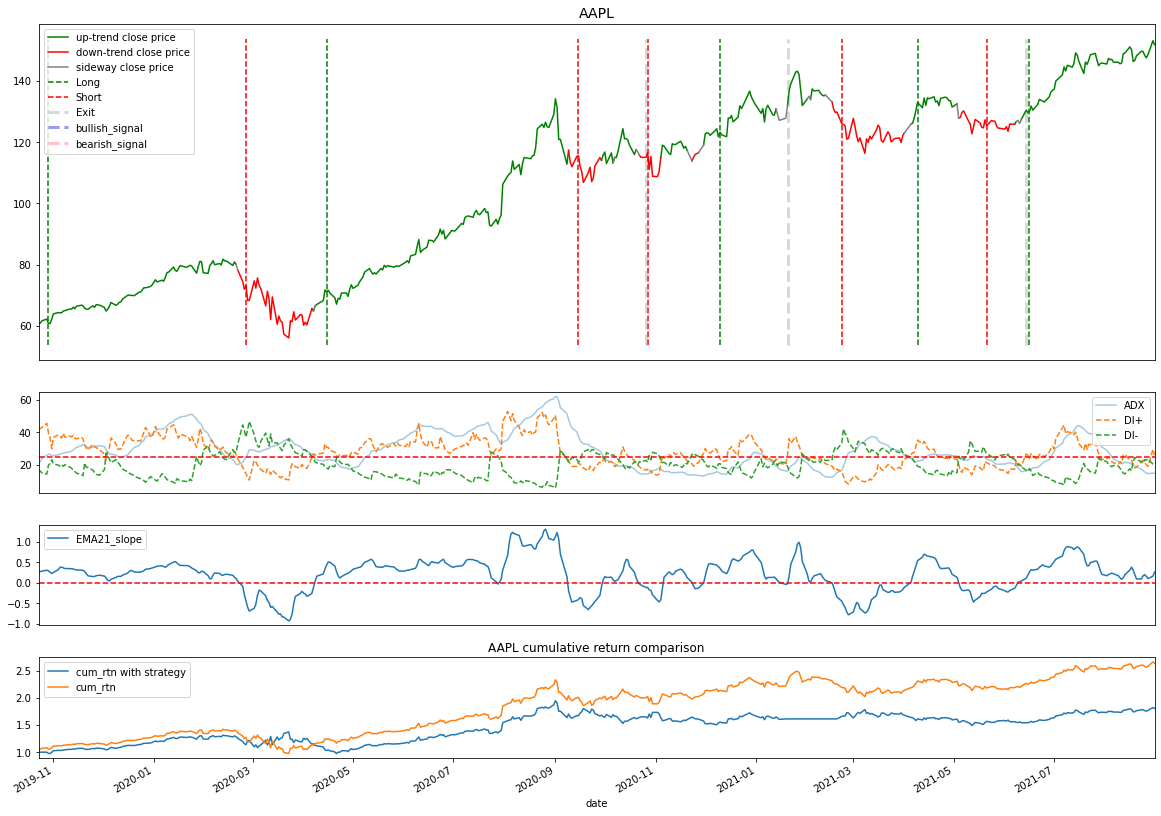

In [177]:
# ticker = 'AEE'
ticker = 'AAPL'
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

today = datetime.today().strftime('%Y-%m-%d')
delta = dateutil.relativedelta.relativedelta(months = int(12 * 2))
begin = (datetime.today() - delta).strftime('%Y-%m-%d')
# today = '2020-05-01'
# begin = '2020-01-01'

stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
{ticker}?from={begin}&to={today}&apikey={fm_key}').json()
stock = pd.DataFrame(stock['historical'])
stock = stock.sort_values('date').reset_index(drop = True)
stock['date'] = pd.to_datetime(stock['date'])
stock['Date'] = stock['date'].apply(mpl_dates.date2num)

def MA(tp, n):
    ma = tp.rolling(window = n).mean()
    return ma

def EMA(close, n):
    ema = close.ewm(span = n).mean()
    return ema

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def Bounds(tp, sma, n, m):
    std = tp.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

def ADX(stock, n = 14):
    
    stock['hl'] = stock['high'] - stock['low']
    stock['hc'] = abs(stock['high'] - stock['close'].shift())
    stock['lc'] = abs(stock['low'] - stock['close'].shift())
    stock['TR'] = stock[['hl', 'hc', 'lc']].max(axis = 1, skipna = False)
    
    temp = sum(stock.TR.isna())
    stock['sm_tr'] = np.nan
    stock.loc[n-1+temp,'sm_tr'] = stock.TR[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'sm_tr'] = stock.loc[i-1,'sm_tr'] - stock.loc[i-1,'sm_tr']/n + stock.loc[i,'TR']
        
    stock['pos_dm'] = np.where((stock.high-stock.high.shift()) > (stock.low.shift()-stock.low),\
                               stock.high-stock.high.shift(), 0)
    stock['neg_dm'] = np.where((stock.high-stock.high.shift()) < (stock.low.shift()-stock.low),\
                              stock.low.shift()-stock.low, 0)
        
    stock['pos_di'] = np.nan
    temp = sum(stock.pos_dm.isna())
    stock.loc[n-1+temp,'pos_di'] = stock.pos_dm[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'pos_di'] = stock.loc[i-1,'pos_di'] - stock.loc[i-1,'pos_di']/n + stock.loc[i,'pos_dm']
    stock.pos_di = (stock.pos_di / stock.sm_tr) * 100
    
    stock['neg_di'] = np.nan
    temp = sum(stock.neg_dm.isna())
    stock.loc[n-1+temp,'neg_di'] = stock.pos_dm[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'neg_di'] = stock.loc[i-1,'neg_di'] - stock.loc[i-1,'neg_di']/n + stock.loc[i,'neg_dm']
    stock.neg_di = (stock.neg_di / stock.sm_tr) * 100
    
    stock['dx'] = (abs(stock.pos_di - stock.neg_di) / abs(stock.pos_di + stock.neg_di)) * 100
    
    temp = sum(stock.dx.isna())
    stock.loc[n-1+temp,'ADX'] = stock.dx[temp:n-1+temp].mean()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'ADX'] = (stock.loc[i-1,'ADX'] * (n-1) + stock.loc[i,'dx']) / n
        
def dragonfly(open, high, low, close):
    if (abs(close - open)/(high - low) < 0.1)\
    & ((min(close, open) - low) > (3 * abs(close - open)))\
    & (high - max(close, open) < abs(close - open)):
        return True
    else:
        return False
    
def gravestone(open, high, low, close):
    if ((abs(close - open) / (high - low) < 0.1)\
        & ((high - max(close, open)) > (3 * abs(close - open)))\
        & ((min(close, open) - low) <= abs(close - open))):
        return True
    else:
        return False
    
def doji(open, high, low, close):
    if (abs(close - open) / (high - low) < 0.1)\
    & ((high - max(close, open)) > (3 * abs(close - open)))\
    & ((min(close, open) - low) > (3 * abs(close - open))):
        return True
    else:
        return False
    

stock['open_ma'] = MA(stock['open'], 3)
stock['close_ma'] = MA(stock['close'], 3)
stock['high_ma'] = MA(stock['high'], 3)
stock['low_ma'] = MA(stock['low'], 3)
stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
stock['EMA21_slope'] = stock['EMA21'].rolling(5).apply(calc_slope)
# stock['EMA44_slope'] = stock['EMA44'].rolling(5).apply(calc_slope)
# stock['EMA21_30_slope'] = stock['EMA21'].rolling(30).apply(calc_slope)

# import talib
# stock['ADX_stand'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)
ADX(stock, n = 14)

stock = stock.dropna()
stock.reset_index(drop = True, inplace = True)

up = []
down = []
sideway = []

if ((stock.loc[0,'pos_di'] > stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] > 0))\
& ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.05)):   
    
    up.append(stock.loc[0,'date'])

elif ((stock.loc[0,'pos_di'] < stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] < 0))\
& ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.05)):

    down.append(stock.loc[0,'date'])

else:
    sideway.append(stock.loc[0,'date'])

for i in range(1, len(stock)):
    if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
    & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.05)):   
        
        if stock.loc[i-1,'date'] not in up:
            up.append(stock.loc[i-1,'date'])
        up.append(stock.loc[i,'date'])
        
    elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
    & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.05)):
        
        if stock.loc[i-1,'date'] not in down:
            down.append(stock.loc[i-1,'date'])
        down.append(stock.loc[i,'date'])
        
    else:
        
        if stock.loc[i-1,'date'] not in sideway:
            sideway.append(stock.loc[i-1,'date'])
        sideway.append(stock.loc[i,'date'])

# for i in range(len(stock)):
#     if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
#     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.1)):   

#         up.append(stock.loc[i,'date'])

#     elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
#     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.1)):

#         down.append(stock.loc[i,'date'])

#     else:
#         sideway.append(stock.loc[i,'date'])

stock['pos'] = np.nan # position for next day
ts = 0 # trading signal
long = [] # long
short = [] # short
exit = []
bullish_signal = []
bearish_signal = []
        
for d in range(7,len(stock)):
    # down-trend
    if stock.loc[d-1,'date'] in down:
        # bullish signal by Fibonacci
        if (stock.loc[d-1,'close'] < stock.loc[d-4,'close'] < stock.loc[d-6,'close'] < stock.loc[d-7,'close']):
            # fib_bull.append(stock.loc[d,'date']) # signal recognized
            # fibonacci bullish signal confirmation
            if (stock.loc[d,'close'] > stock.loc[d-1,'close']):
                
                #if doji(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']):
                if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
                | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
                | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
                #if (stock.loc[d,'open_ma'] == stock.loc[d,'close_ma'])\
                #& (stock.loc[d,'close_ma'] < stock.loc[d-1,'close_ma'] < stock.loc[d-2,'close_ma']):
                    bullish_signal.append(stock.loc[d,'date']) # signal confirmed
                    if (ts != 1):
                        long.append(stock.loc[d+2,'date'])
                        ts = 1

            # bullish signal invalid, still bearish
            elif (stock.loc[d,'close'] < stock.loc[d-1,'close']):
                if (ts != -1):
                    short.append(stock.loc[d+2,'date'])
                    ts = -1

                    
    # up-trend
    elif stock.loc[d-1,'date'] in up:
        # bearish signal by Fibonacci
        if (stock.loc[d-1,'close'] > stock.loc[d-4,'close'] > stock.loc[d-6,'close'] > stock.loc[d-7,'close']):
            #fib_bear.append(stock.loc[d,'date']) #signal recognized
            # bearish signal confirmation
            if (stock.loc[d,'close'] < stock.loc[d-1,'close']):
                
                #if doji(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']):
                #if (gravestone(stock.loc[d,'open_ma'], stock.loc[d,'high_ma'], stock.loc[d,'low_ma'], stock.loc[d,'close_ma']))\
                #| gravestone(stock.loc[d-1,'open_ma'], stock.loc[d-1,'high_ma'], stock.loc[d-1,'low_ma'], stock.loc[d-1,'close_ma'])\
                #| gravestone(stock.loc[d-2,'open_ma'], stock.loc[d-2,'high_ma'], stock.loc[d-2,'low_ma'], stock.loc[d-2,'close_ma']):
                if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
                | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
                | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
                #if (stock.loc[d,'open_ma'] == stock.loc[d,'close_ma'])\
                #& (stock.loc[d,'close_ma'] > stock.loc[d-1,'close_ma'] > stock.loc[d-2,'close_ma']):
                    bearish_signal.append(stock.loc[d,'date']) #signal confirmed
                    if (ts != -1):
                        short.append(stock.loc[d+2,'date'])
                        ts = -1

            # bearish signal invalide, still bullish
            elif (stock.loc[d,'close'] > stock.loc[d-1,'close']):
                if (ts != 1):
                    long.append(stock.loc[d+2,'date'])
                    ts = 1

    
    #stock.loc[d+2,'pos'] = ts
    
    elif stock.loc[d-1,'date'] in sideway:
        if (ts != 0):
            exit.append(stock.loc[d+2,'date'])
            ts = 0
            
    stock.loc[d+2,'pos'] = ts


stock = stock.set_index('date')

# stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
stock['rtn_s'] = stock['close'].pct_change() * stock['pos']
stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

stock['rtn'] = stock['close'].pct_change()
stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

stock = stock.dropna()
        
stock['up_close'] = np.where(stock.index.isin(up), stock.close, np.nan)
stock['down_close'] = np.where(stock.index.isin(down), stock.close, np.nan)
stock['sideway_close'] = np.where(stock.index.isin(sideway), stock.close, np.nan)

plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.xmargin'] = 0
fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 3, 3, 3]})

# data_plot = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]
# candlestick_ohlc(axs[0], data_plot.values, width = 0.6,\
#                  colorup = 'green', colordown = 'red', alpha=0.8)

stock['up_close'].plot(label = 'up-trend close price', ax = axs[0], color = 'green')
stock['down_close'].plot(label = 'down-trend close price', ax = axs[0], color = 'red')
stock['sideway_close'].plot(label = 'sideway close price', ax = axs[0], color = 'grey')
# stock['close'].plot(label = 'Close price', ax = axs[0], color = 'skyblue', alpha = 0.5)
# stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
# stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), max(stock.EMA21))

axs[0].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 1)
axs[0].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 1)
axs[0].vlines(exit, ymin = ymin, ymax = ymax,\
              color = 'grey', linestyle = '--', label = 'Exit', alpha = 0.3, lw = 3)

axs[0].vlines(bullish_signal, ymin = ymin, ymax = ymax,\
              color = 'blue', linestyle = '--', label = 'bullish_signal', alpha = 0.4, lw = 3)
axs[0].vlines(bearish_signal, ymin = ymin, ymax = ymax,\
              color = 'pink', linestyle = '--', label = 'bearish_signal', alpha = 1, lw = 3)

stock['ADX'].plot(label = 'ADX', alpha = 0.4, ax = axs[1])
stock['pos_di'].plot(label = 'DI+', linestyle = '--', ax = axs[1])
stock['neg_di'].plot(label = 'DI-', linestyle = '--', ax = axs[1])
axs[1].axhline(25, color = 'red', linestyle = '--')

stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
# stock['EMA21_30_slope'].plot(label = 'EMA21_30_slope', ax = axs[2])
# stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
axs[2].axhline(0, color = 'red', linestyle = '--')

stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])

axs[0].set(xlabel = '')
axs[1].set(xlabel = '')
axs[2].set(xlabel = '')
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[0].set_title(f'{ticker}', fontsize = 14)
axs[3].set_title(f'{ticker} cumulative return comparison')

plt.show()

## Test 2

In [176]:
# ticker = 'AEE'
# fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

# today = datetime.today().strftime('%Y-%m-%d')
# delta = dateutil.relativedelta.relativedelta(months = int(12 * 2))
# begin = (datetime.today() - delta).strftime('%Y-%m-%d')
# # today = '2020-05-01'
# # begin = '2020-01-01'

# stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
# {ticker}?from={begin}&to={today}&apikey={fm_key}').json()
# stock = pd.DataFrame(stock['historical'])
# stock = stock.sort_values('date').reset_index(drop = True)
# stock['date'] = pd.to_datetime(stock['date'])
# stock['Date'] = stock['date'].apply(mpl_dates.date2num)

# def MA(tp, n):
#     ma = tp.rolling(window = n).mean()
#     return ma

# def EMA(close, n):
#     ema = close.ewm(span = n).mean()
#     return ema

# def calc_slope(x):
#     slope = np.polyfit(range(len(x)), x, 1)[0]
#     return slope

# def Bounds(tp, sma, n, m):
#     std = tp.rolling(window = n).std()
#     BOLU = sma + std * m
#     BOLD = sma - std * m
#     return BOLU, BOLD

# def ADX(stock, n = 14):
    
#     stock['hl'] = stock['high'] - stock['low']
#     stock['hc'] = abs(stock['high'] - stock['close'].shift())
#     stock['lc'] = abs(stock['low'] - stock['close'].shift())
#     stock['TR'] = stock[['hl', 'hc', 'lc']].max(axis = 1, skipna = False)
    
#     temp = sum(stock.TR.isna())
#     stock['sm_tr'] = np.nan
#     stock.loc[n-1+temp,'sm_tr'] = stock.TR[temp:n-1+temp].sum()
#     for i in range(n+temp, len(stock)):
#         stock.loc[i,'sm_tr'] = stock.loc[i-1,'sm_tr'] - stock.loc[i-1,'sm_tr']/n + stock.loc[i,'TR']
        
#     stock['pos_dm'] = np.where((stock.high-stock.high.shift()) > (stock.low.shift()-stock.low),\
#                                stock.high-stock.high.shift(), 0)
#     stock['neg_dm'] = np.where((stock.high-stock.high.shift()) < (stock.low.shift()-stock.low),\
#                               stock.low.shift()-stock.low, 0)
        
#     stock['pos_di'] = np.nan
#     temp = sum(stock.pos_dm.isna())
#     stock.loc[n-1+temp,'pos_di'] = stock.pos_dm[temp:n-1+temp].sum()
#     for i in range(n+temp, len(stock)):
#         stock.loc[i,'pos_di'] = stock.loc[i-1,'pos_di'] - stock.loc[i-1,'pos_di']/n + stock.loc[i,'pos_dm']
#     stock.pos_di = (stock.pos_di / stock.sm_tr) * 100
    
#     stock['neg_di'] = np.nan
#     temp = sum(stock.neg_dm.isna())
#     stock.loc[n-1+temp,'neg_di'] = stock.pos_dm[temp:n-1+temp].sum()
#     for i in range(n+temp, len(stock)):
#         stock.loc[i,'neg_di'] = stock.loc[i-1,'neg_di'] - stock.loc[i-1,'neg_di']/n + stock.loc[i,'neg_dm']
#     stock.neg_di = (stock.neg_di / stock.sm_tr) * 100
    
#     stock['dx'] = (abs(stock.pos_di - stock.neg_di) / abs(stock.pos_di + stock.neg_di)) * 100
    
#     temp = sum(stock.dx.isna())
#     stock.loc[n-1+temp,'ADX'] = stock.dx[temp:n-1+temp].mean()
#     for i in range(n+temp, len(stock)):
#         stock.loc[i,'ADX'] = (stock.loc[i-1,'ADX'] * (n-1) + stock.loc[i,'dx']) / n
        
# def dragonfly(open, high, low, close):
#     if (abs(close - open)/(high - low) < 0.1)\
#     & ((min(close, open) - low) > (3 * abs(close - open)))\
#     & (high - max(close, open) < abs(close - open)):
#         return True
#     else:
#         return False
    
# def doji(open, high, low, close):
#     if (abs(close - open) / (high - low) < 0.1)\
#     & ((high - max(close, open)) > (3 * abs(close - open)))\
#     & ((min(close, open) - low) > (3 * abs(close - open))):
#         return True
#     else:
#         return False
    

# stock['open_ma'] = MA(stock['open'], 3)
# stock['close_ma'] = MA(stock['close'], 3)
# stock['high_ma'] = MA(stock['high'], 3)
# stock['low_ma'] = MA(stock['low'], 3)
# stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
# stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
# stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
# stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
# stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
# stock['EMA21_slope'] = stock['EMA21'].rolling(5).apply(calc_slope)
# # stock['EMA44_slope'] = stock['EMA44'].rolling(5).apply(calc_slope)
# # stock['EMA21_30_slope'] = stock['EMA21'].rolling(30).apply(calc_slope)

# # import talib
# # stock['ADX_stand'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)
# ADX(stock, n = 14)

# stock = stock.dropna()
# stock.reset_index(drop = True, inplace = True)

# up = []
# down = []
# sideway = []

# # for i in range(len(stock)):
# #     if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
# #     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.1)):
# #         up.append(stock.loc[i,'date'])
# #     elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
# #     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.1)):
# #         down.append(stock.loc[i,'date'])
# #     else:
# #         sideway.append(stock.loc[i,'date'])

# if ((stock.loc[0,'pos_di'] > stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] > 0))\
# & ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.01)):   
    
#     up.append(stock.loc[0,'date'])

# elif ((stock.loc[0,'pos_di'] < stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] < 0))\
# & ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.01)):

#     down.append(stock.loc[0,'date'])

# else:
#     sideway.append(stock.loc[0,'date'])

# for i in range(1, len(stock)):
#     if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
#     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.01)):   
        
#         if stock.loc[i-1,'date'] not in up:
#             up.append(stock.loc[i-1,'date'])
#         up.append(stock.loc[i,'date'])
        
#     elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
#     & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.01)):
        
#         if stock.loc[i-1,'date'] not in down:
#             down.append(stock.loc[i-1,'date'])
#         down.append(stock.loc[i,'date'])
        
#     else:
        
#         if stock.loc[i-1,'date'] not in sideway:
#             sideway.append(stock.loc[i-1,'date'])
#         sideway.append(stock.loc[i,'date'])

# stock['pos'] = np.nan # position for next day
# ts = 0 # trading signal
# long = [] # long
# short = [] # short
# exit = []
# bullish_signal = []
# bearish_signal = []
        
# for d in range(7,len(stock)):
#     # down-trend
#     if stock.loc[d-1,'date'] in down:
#         if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
#         | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
#         | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
#             if (stock.loc[d-1,'close'] < stock.loc[d-4,'close'] < stock.loc[d-6,'close'] < stock.loc[d-7,'close'])\
#             & (stock.loc[d,'close'] > stock.loc[d-1,'close']):
#                 print(str(stock.loc[d,'date']) + ': ' + 'bullish signal')
#                 bullish_signal.append(stock.loc[d,'date']) # signal confirmed
#                 if (ts != 1):
#                     long.append(stock.loc[d,'date'])
#                     ts = 1
#             # bullish signal invalid, still bearish
#             elif (stock.loc[d,'close'] < stock.loc[d-1,'close']):
#                 if (ts != -1):
#                     short.append(stock.loc[d,'date'])
#                     ts = -1
                    
#     # up-trend
#     if stock.loc[d-1,'date'] in up:
#         if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
#         | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
#         | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
            
#             if (stock.loc[d-1,'close'] > stock.loc[d-4,'close'] > stock.loc[d-6,'close'] > stock.loc[d-7,'close'])\
#             & (stock.loc[d,'close'] < stock.loc[d-1,'close']):
#                 print(str(stock.loc[d,'date']) + ': ' + 'bearish signal')
#                 bearish_signal.append(stock.loc[d,'date']) #signal confirmed
#                 if (ts != -1):
#                     short.append(stock.loc[d,'date'])
#                     ts = -1
#             # bearish signal invalide, still bullish
#             elif (stock.loc[d,'close'] > stock.loc[d-1,'close']):
#                 if (ts != 1):
#                     long.append(stock.loc[d,'date'])
#                     ts = 1
    
#     #stock.loc[d+3,'pos'] = ts
    
#     if stock.loc[d-1,'date'] in sideway:
#         if (ts != 0):
#             exit.append(stock.loc[d,'date'])
#             ts = 0

#     stock.loc[d+2,'pos'] = ts

# stock = stock.set_index('date')

# # stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
# stock['rtn_s'] = stock['close'].pct_change() * stock['pos']
# stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

# stock['rtn'] = stock['close'].pct_change()
# stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

# stock = stock.dropna()
        
# stock['up_close'] = np.where(stock.index.isin(up), stock.close, np.nan)
# stock['down_close'] = np.where(stock.index.isin(down), stock.close, np.nan)
# stock['sideway_close'] = np.where(stock.index.isin(sideway), stock.close, np.nan)

# plt.rcParams['figure.figsize'] = (20, 15)
# plt.rcParams['axes.xmargin'] = 0
# fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 3, 3, 3]})

# # data_plot = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]
# # candlestick_ohlc(axs[0], data_plot.values, width = 0.6,\
# #                  colorup = 'green', colordown = 'red', alpha=0.8)

# stock['up_close'].plot(label = 'up-trend close price', ax = axs[0], color = 'green')
# stock['down_close'].plot(label = 'down-trend close price', ax = axs[0], color = 'red')
# stock['sideway_close'].plot(label = 'sideway close price', ax = axs[0], color = 'grey')
# # stock['close'].plot(label = 'Close price', ax = axs[0], color = 'skyblue', alpha = 0.5)
# # stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
# # stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

# ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
# ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), min(stock.EMA21))

# axs[0].vlines(long, ymin = ymin, ymax = ymax,\
#               color = 'green', linestyle = '--', label = 'Long', alpha = 1)
# axs[0].vlines(short, ymin = ymin, ymax = ymax,\
#               color = 'red', linestyle = '--', label = 'Short', alpha = 1)
# axs[0].vlines(exit, ymin = ymin, ymax = ymax,\
#               color = 'blue', linestyle = '--', label = 'Exit', alpha = 0.3, lw = 3)

# axs[0].vlines(bullish_signal, ymin = ymin, ymax = ymax,\
#               color = 'blue', linestyle = '--', label = 'bullish_signal', alpha = 0.4, lw = 3)
# axs[0].vlines(bearish_signal, ymin = ymin, ymax = ymax,\
#               color = 'pink', linestyle = '--', label = 'bearish_signal', alpha = 1, lw = 3)

# stock['ADX'].plot(label = 'ADX', alpha = 0.4, ax = axs[1])
# stock['pos_di'].plot(label = 'DI+', linestyle = '--', ax = axs[1])
# stock['neg_di'].plot(label = 'DI-', linestyle = '--', ax = axs[1])
# axs[1].axhline(25, color = 'red', linestyle = '--')

# stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
# # stock['EMA21_30_slope'].plot(label = 'EMA21_30_slope', ax = axs[2])
# # stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
# axs[2].axhline(0, color = 'red', linestyle = '--')

# stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
# stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])

# axs[0].set(xlabel = '')
# axs[1].set(xlabel = '')
# axs[2].set(xlabel = '')
# axs[0].set_xticks([])
# axs[1].set_xticks([])
# axs[2].set_xticks([])
# axs[0].legend()
# axs[1].legend()
# axs[2].legend()
# axs[3].legend()
# axs[0].set_title(f'{ticker}', fontsize = 14)
# axs[3].set_title(f'{ticker} cumulative return comparison')

# plt.show()

# Function Test

In [188]:
def fibo_doji(ticker, period = 3):

    import requests
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    import dateutil
    from dateutil.relativedelta import relativedelta
    import mplfinance as mpf
    from mplfinance.original_flavor import candlestick_ohlc
    import matplotlib.dates as mpl_dates

    fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

    today = datetime.today().strftime('%Y-%m-%d')
    delta = dateutil.relativedelta.relativedelta(months = int(12 * period))
    begin = (datetime.today() - delta).strftime('%Y-%m-%d')
    # today = '2020-05-01'
    # begin = '2020-01-01'

    stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
    {ticker}?from={begin}&to={today}&apikey={fm_key}').json()
    stock = pd.DataFrame(stock['historical'])
    stock = stock.sort_values('date').reset_index(drop = True)
    stock['date'] = pd.to_datetime(stock['date'])
    stock['Date'] = stock['date'].apply(mpl_dates.date2num)

    def MA(tp, n):
        ma = tp.rolling(window = n).mean()
        return ma

    def EMA(close, n):
        ema = close.ewm(span = n).mean()
        return ema

    def calc_slope(x):
        slope = np.polyfit(range(len(x)), x, 1)[0]
        return slope

    def Bounds(tp, sma, n, m):
        std = tp.rolling(window = n).std()
        BOLU = sma + std * m
        BOLD = sma - std * m
        return BOLU, BOLD

    def ADX(stock, n = 14):

        stock['hl'] = stock['high'] - stock['low']
        stock['hc'] = abs(stock['high'] - stock['close'].shift())
        stock['lc'] = abs(stock['low'] - stock['close'].shift())
        stock['TR'] = stock[['hl', 'hc', 'lc']].max(axis = 1, skipna = False)

        temp = sum(stock.TR.isna())
        stock['sm_tr'] = np.nan
        stock.loc[n-1+temp,'sm_tr'] = stock.TR[temp:n-1+temp].sum()
        for i in range(n+temp, len(stock)):
            stock.loc[i,'sm_tr'] = stock.loc[i-1,'sm_tr'] - stock.loc[i-1,'sm_tr']/n + stock.loc[i,'TR']

        stock['pos_dm'] = np.where((stock.high-stock.high.shift()) > (stock.low.shift()-stock.low),\
                                   stock.high-stock.high.shift(), 0)
        stock['neg_dm'] = np.where((stock.high-stock.high.shift()) < (stock.low.shift()-stock.low),\
                                  stock.low.shift()-stock.low, 0)

        stock['pos_di'] = np.nan
        temp = sum(stock.pos_dm.isna())
        stock.loc[n-1+temp,'pos_di'] = stock.pos_dm[temp:n-1+temp].sum()
        for i in range(n+temp, len(stock)):
            stock.loc[i,'pos_di'] = stock.loc[i-1,'pos_di'] - stock.loc[i-1,'pos_di']/n + stock.loc[i,'pos_dm']
        stock.pos_di = (stock.pos_di / stock.sm_tr) * 100

        stock['neg_di'] = np.nan
        temp = sum(stock.neg_dm.isna())
        stock.loc[n-1+temp,'neg_di'] = stock.pos_dm[temp:n-1+temp].sum()
        for i in range(n+temp, len(stock)):
            stock.loc[i,'neg_di'] = stock.loc[i-1,'neg_di'] - stock.loc[i-1,'neg_di']/n + stock.loc[i,'neg_dm']
        stock.neg_di = (stock.neg_di / stock.sm_tr) * 100

        stock['dx'] = (abs(stock.pos_di - stock.neg_di) / abs(stock.pos_di + stock.neg_di)) * 100

        temp = sum(stock.dx.isna())
        stock.loc[n-1+temp,'ADX'] = stock.dx[temp:n-1+temp].mean()
        for i in range(n+temp, len(stock)):
            stock.loc[i,'ADX'] = (stock.loc[i-1,'ADX'] * (n-1) + stock.loc[i,'dx']) / n

    def dragonfly(open, high, low, close):
        if (abs(close - open)/(high - low) < 0.1)\
        & ((min(close, open) - low) > (3 * abs(close - open)))\
        & (high - max(close, open) < abs(close - open)):
            return True
        else:
            return False

    def gravestone(open, high, low, close):
        if ((abs(close - open) / (high - low) < 0.1)\
            & ((high - max(close, open)) > (3 * abs(close - open)))\
            & ((min(close, open) - low) <= abs(close - open))):
            return True
        else:
            return False

    def doji(open, high, low, close):
        if (abs(close - open) / (high - low) < 0.1)\
        & ((high - max(close, open)) > (3 * abs(close - open)))\
        & ((min(close, open) - low) > (3 * abs(close - open))):
            return True
        else:
            return False


    stock['open_ma'] = MA(stock['open'], 3)
    stock['close_ma'] = MA(stock['close'], 3)
    stock['high_ma'] = MA(stock['high'], 3)
    stock['low_ma'] = MA(stock['low'], 3)
    stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
    stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
    stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
    stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
    stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
    stock['EMA21_slope'] = stock['EMA21'].rolling(5).apply(calc_slope)
    # stock['EMA44_slope'] = stock['EMA44'].rolling(5).apply(calc_slope)
    # stock['EMA21_30_slope'] = stock['EMA21'].rolling(30).apply(calc_slope)

    # import talib
    # stock['ADX_stand'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)
    ADX(stock, n = 14)

    stock = stock.dropna()
    stock.reset_index(drop = True, inplace = True)

    up = []
    down = []
    sideway = []

    if ((stock.loc[0,'pos_di'] > stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] > 0))\
    & ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.01)):   

        up.append(stock.loc[0,'date'])

    elif ((stock.loc[0,'pos_di'] < stock.loc[0,'neg_di']) | (stock.loc[0,'EMA21_slope'] < 0))\
    & ((stock.loc[0, 'ADX'] > 25) | (abs(stock.loc[0,'EMA21_slope']) > 0.01)):

        down.append(stock.loc[0,'date'])

    else:
        sideway.append(stock.loc[0,'date'])

    for i in range(1, len(stock)):
        if ((stock.loc[i,'pos_di'] > stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] > 0))\
        & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.01)):   

            if stock.loc[i-1,'date'] not in up:
                up.append(stock.loc[i-1,'date'])
            up.append(stock.loc[i,'date'])

        elif ((stock.loc[i,'pos_di'] < stock.loc[i,'neg_di']) | (stock.loc[i,'EMA21_slope'] < 0))\
        & ((stock.loc[i, 'ADX'] > 25) | (abs(stock.loc[i,'EMA21_slope']) > 0.01)):

            if stock.loc[i-1,'date'] not in down:
                down.append(stock.loc[i-1,'date'])
            down.append(stock.loc[i,'date'])

        else:

            if stock.loc[i-1,'date'] not in sideway:
                sideway.append(stock.loc[i-1,'date'])
            sideway.append(stock.loc[i,'date'])


    stock['pos'] = np.nan # position for next day
    ts = 0 # trading signal
    long = [] # long
    short = [] # short
    exit = []
    bullish_signal = []
    bearish_signal = []

    for d in range(7,len(stock)-1):
        # down-trend
        if stock.loc[d-1,'date'] in down:
            # bullish signal by Fibonacci
            if (stock.loc[d-1,'close'] < stock.loc[d-4,'close'] < stock.loc[d-6,'close'] < stock.loc[d-7,'close']):
                # fib_bull.append(stock.loc[d,'date']) # signal recognized
                # fibonacci bullish signal confirmation
                if (stock.loc[d,'close'] > stock.loc[d-1,'close']):

                    #if doji(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']):
                    if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
                    | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
                    | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
                    #if (stock.loc[d,'open_ma'] == stock.loc[d,'close_ma'])\
                    #& (stock.loc[d,'close_ma'] < stock.loc[d-1,'close_ma'] < stock.loc[d-2,'close_ma']):
                        bullish_signal.append(stock.loc[d,'date']) # signal confirmed
                        if (ts != 1):
                            long.append(stock.loc[d+2,'date'])
                            ts = 1

                # bullish signal invalid, still bearish
                elif (stock.loc[d,'close'] < stock.loc[d-1,'close']):
                    if (ts != -1):
                        short.append(stock.loc[d+2,'date'])
                        ts = -1


        # up-trend
        elif stock.loc[d-1,'date'] in up:
            # bearish signal by Fibonacci
            if (stock.loc[d-1,'close'] > stock.loc[d-4,'close'] > stock.loc[d-6,'close'] > stock.loc[d-7,'close']):
                #fib_bear.append(stock.loc[d,'date']) #signal recognized
                # bearish signal confirmation
                if (stock.loc[d,'close'] < stock.loc[d-1,'close']):

                    #if doji(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']):
                    #if (gravestone(stock.loc[d,'open_ma'], stock.loc[d,'high_ma'], stock.loc[d,'low_ma'], stock.loc[d,'close_ma']))\
                    #| gravestone(stock.loc[d-1,'open_ma'], stock.loc[d-1,'high_ma'], stock.loc[d-1,'low_ma'], stock.loc[d-1,'close_ma'])\
                    #| gravestone(stock.loc[d-2,'open_ma'], stock.loc[d-2,'high_ma'], stock.loc[d-2,'low_ma'], stock.loc[d-2,'close_ma']):
                    if (dragonfly(stock.loc[d,'open'], stock.loc[d,'high'], stock.loc[d,'low'], stock.loc[d,'close']))\
                    | dragonfly(stock.loc[d-1,'open'], stock.loc[d-1,'high'], stock.loc[d-1,'low'], stock.loc[d-1,'close'])\
                    | dragonfly(stock.loc[d-2,'open'], stock.loc[d-2,'high'], stock.loc[d-2,'low'], stock.loc[d-2,'close']):
                    #if (stock.loc[d,'open_ma'] == stock.loc[d,'close_ma'])\
                    #& (stock.loc[d,'close_ma'] > stock.loc[d-1,'close_ma'] > stock.loc[d-2,'close_ma']):
                        bearish_signal.append(stock.loc[d,'date']) #signal confirmed
                        if (ts != -1):
                            short.append(stock.loc[d+2,'date'])
                            ts = -1

                # bearish signal invalide, still bullish
                elif (stock.loc[d,'close'] > stock.loc[d-1,'close']):
                    if (ts != 1):
                        long.append(stock.loc[d+2,'date'])
                        ts = 1


        #stock.loc[d+2,'pos'] = ts

        elif (stock.loc[d-2,'date'] in sideway)\
        & (stock.loc[d-1,'date'] in sideway)\
        & (stock.loc[d,'date'] in sideway):
            if (ts != 0):
                exit.append(stock.loc[d+2,'date'])
                ts = 0

        stock.loc[d+2,'pos'] = ts


    stock = stock.set_index('date')

    # stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
    stock['rtn_s'] = stock['close'].pct_change() * stock['pos']
    stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

    stock['rtn'] = stock['close'].pct_change()
    stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

    stock = stock.dropna()

    stock['up_close'] = np.where(stock.index.isin(up), stock.close, np.nan)
    stock['down_close'] = np.where(stock.index.isin(down), stock.close, np.nan)
    stock['sideway_close'] = np.where(stock.index.isin(sideway), stock.close, np.nan)

    plt.rcParams['figure.figsize'] = (20, 15)
    plt.rcParams['axes.xmargin'] = 0
    fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 3, 3, 3]})

    # data_plot = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]
    # candlestick_ohlc(axs[0], data_plot.values, width = 0.6,\
    #                  colorup = 'green', colordown = 'red', alpha=0.8)

    stock['up_close'].plot(label = 'up-trend close price', ax = axs[0], color = 'green')
    stock['down_close'].plot(label = 'down-trend close price', ax = axs[0], color = 'red')
    stock['sideway_close'].plot(label = 'sideway close price', ax = axs[0], color = 'grey')
    # stock['close'].plot(label = 'Close price', ax = axs[0], color = 'skyblue', alpha = 0.5)
    # stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
    # stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

    ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
    ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), max(stock.EMA21))

    axs[0].vlines(long, ymin = ymin, ymax = ymax,\
                  color = 'green', linestyle = '--', label = 'Long', alpha = 1)
    axs[0].vlines(short, ymin = ymin, ymax = ymax,\
                  color = 'red', linestyle = '--', label = 'Short', alpha = 1)
    axs[0].vlines(exit, ymin = ymin, ymax = ymax,\
                  color = 'grey', linestyle = '--', label = 'Exit', alpha = 0.3, lw = 3)

    axs[0].vlines(bullish_signal, ymin = ymin, ymax = ymax,\
                  color = 'blue', linestyle = '--', label = 'bullish_signal', alpha = 0.4, lw = 3)
    axs[0].vlines(bearish_signal, ymin = ymin, ymax = ymax,\
                  color = 'pink', linestyle = '--', label = 'bearish_signal', alpha = 1, lw = 3)

    stock['ADX'].plot(label = 'ADX', alpha = 0.4, ax = axs[1])
    stock['pos_di'].plot(label = 'DI+', linestyle = '--', ax = axs[1])
    stock['neg_di'].plot(label = 'DI-', linestyle = '--', ax = axs[1])
    axs[1].axhline(25, color = 'red', linestyle = '--')

    stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
    # stock['EMA21_30_slope'].plot(label = 'EMA21_30_slope', ax = axs[2])
    # stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
    axs[2].axhline(0, color = 'red', linestyle = '--')

    stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
    stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])

    axs[0].set(xlabel = '')
    axs[1].set(xlabel = '')
    axs[2].set(xlabel = '')
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[2].set_xticks([])
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()
    axs[0].set_title(f'{ticker}', fontsize = 14)
    axs[3].set_title(f'{ticker} cumulative return comparison')

    plt.show()

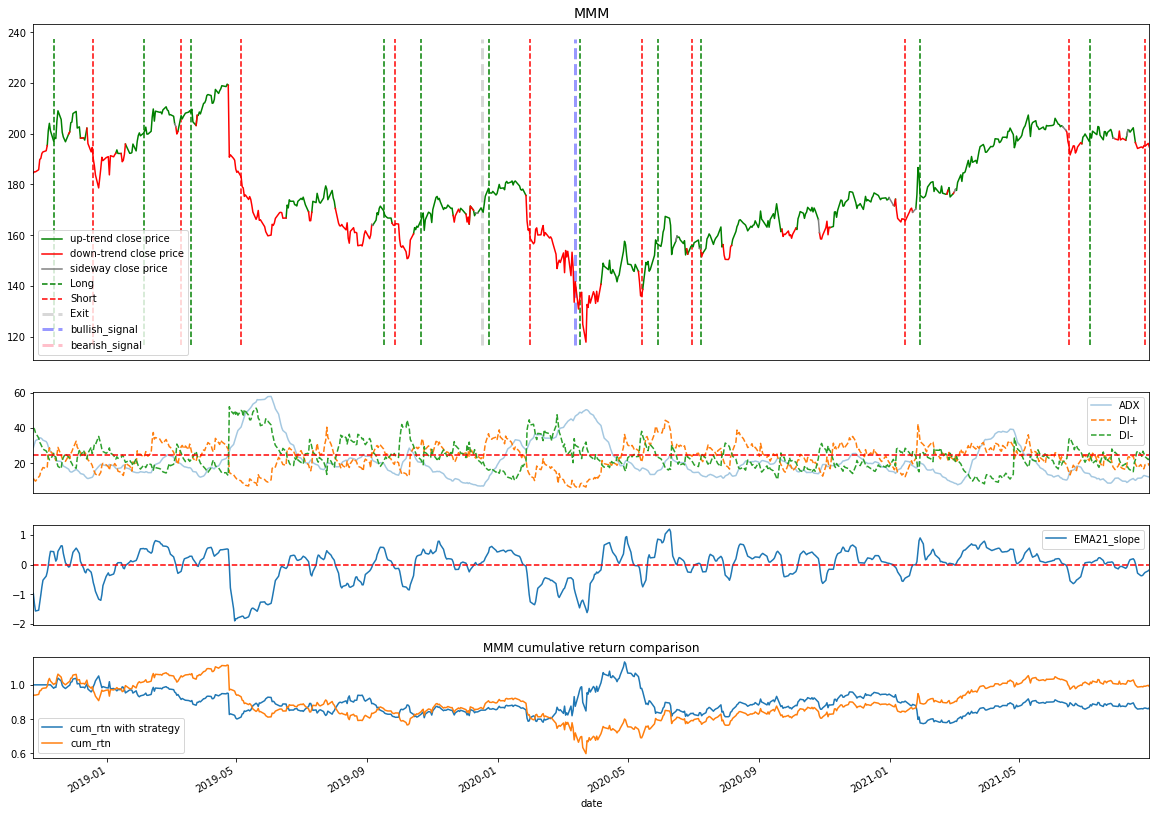

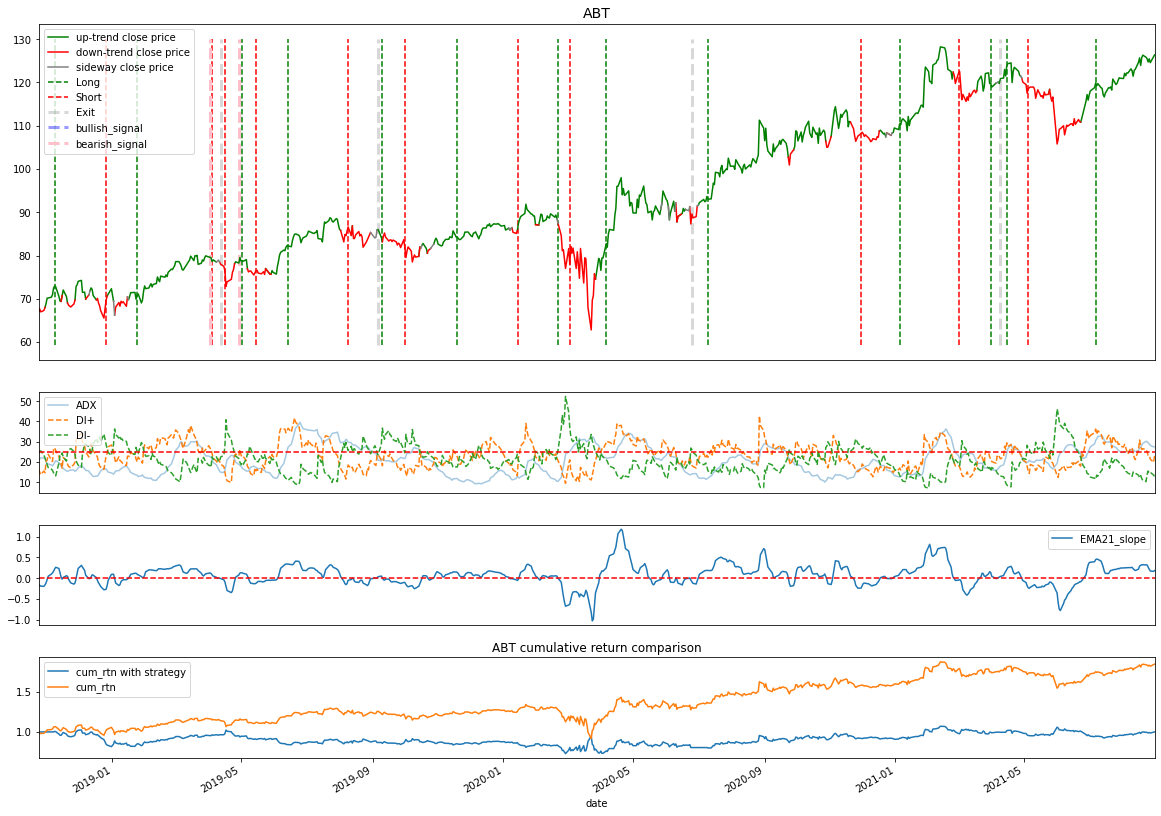

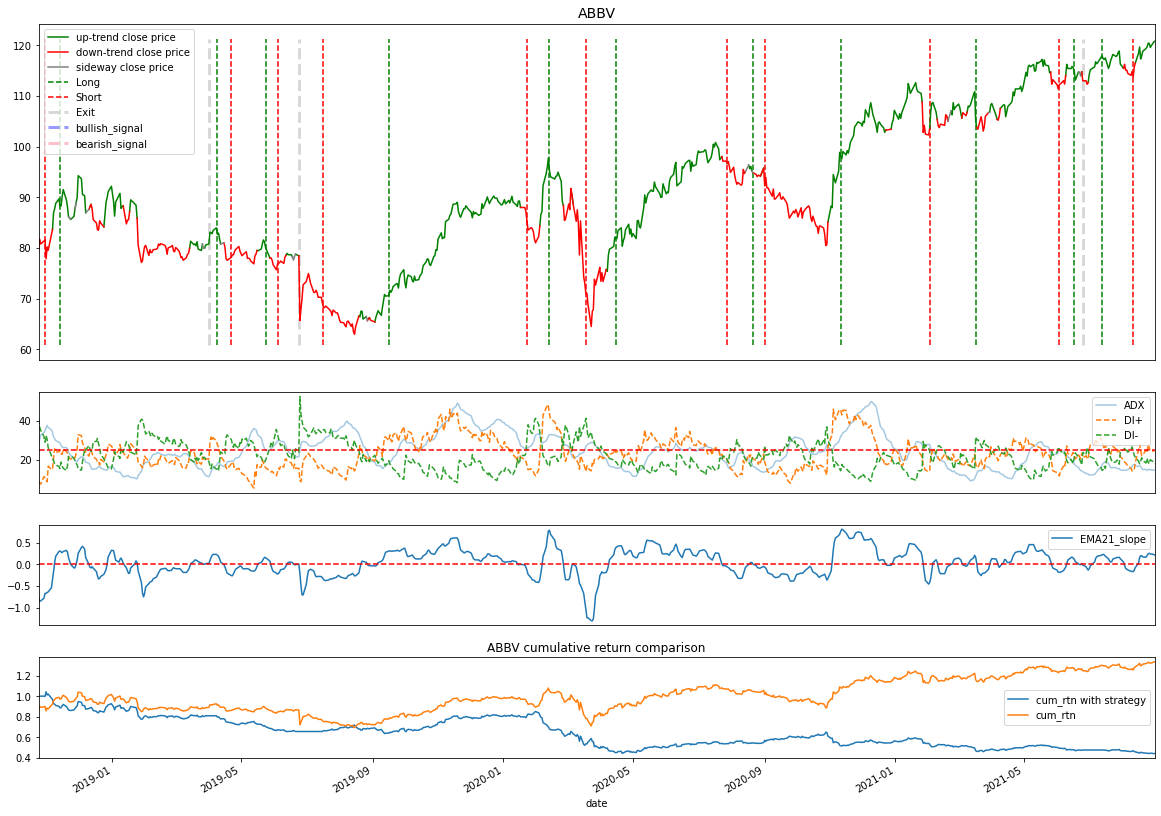

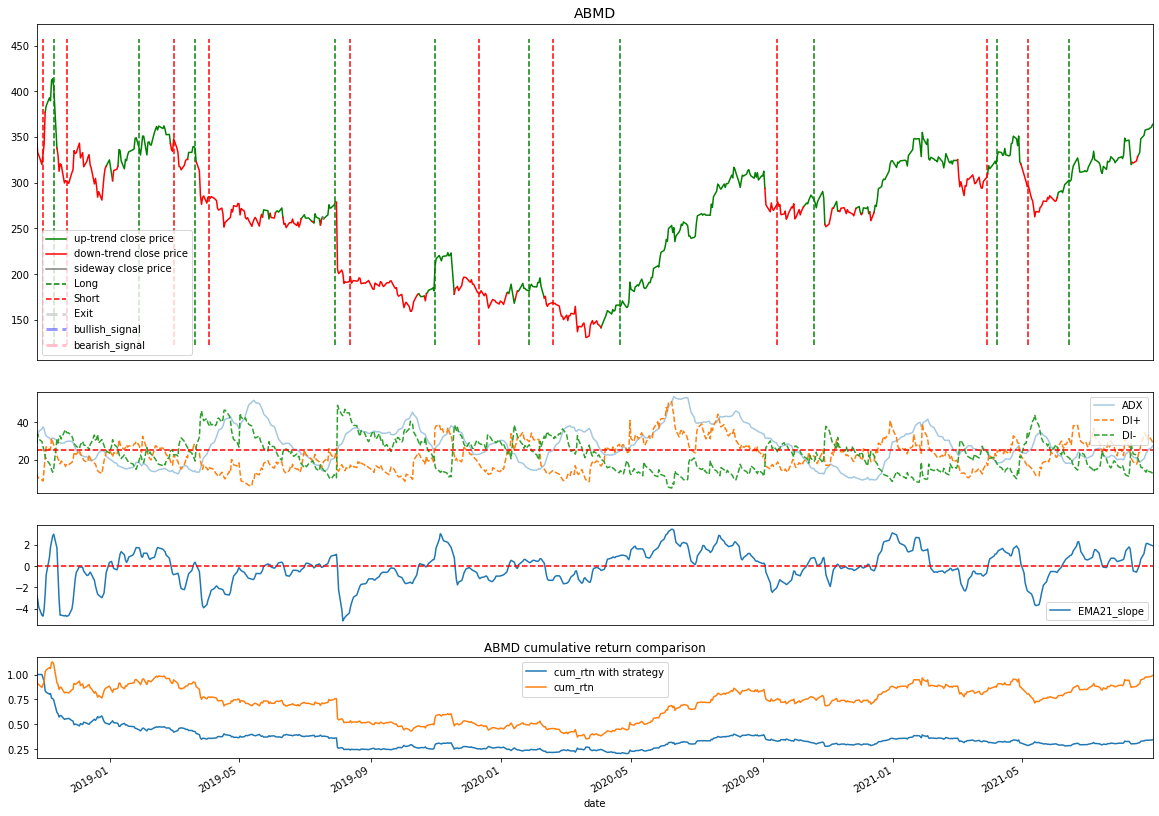

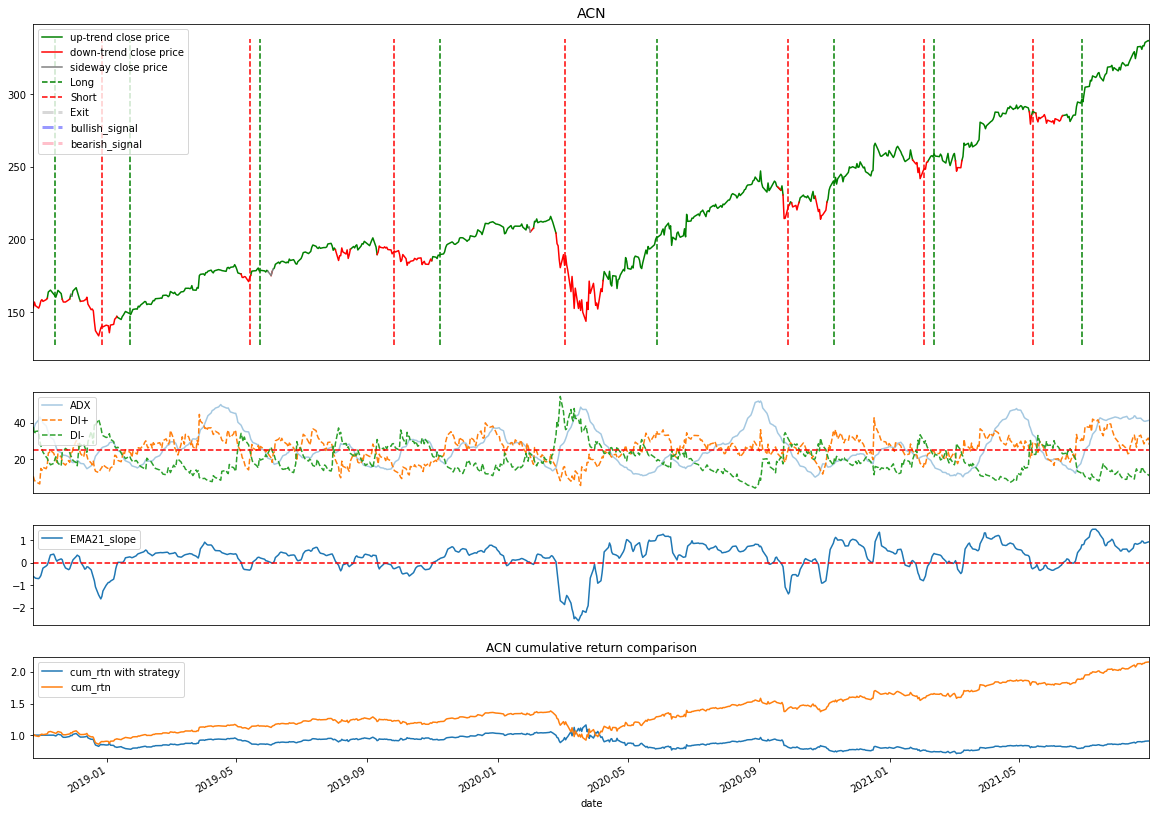

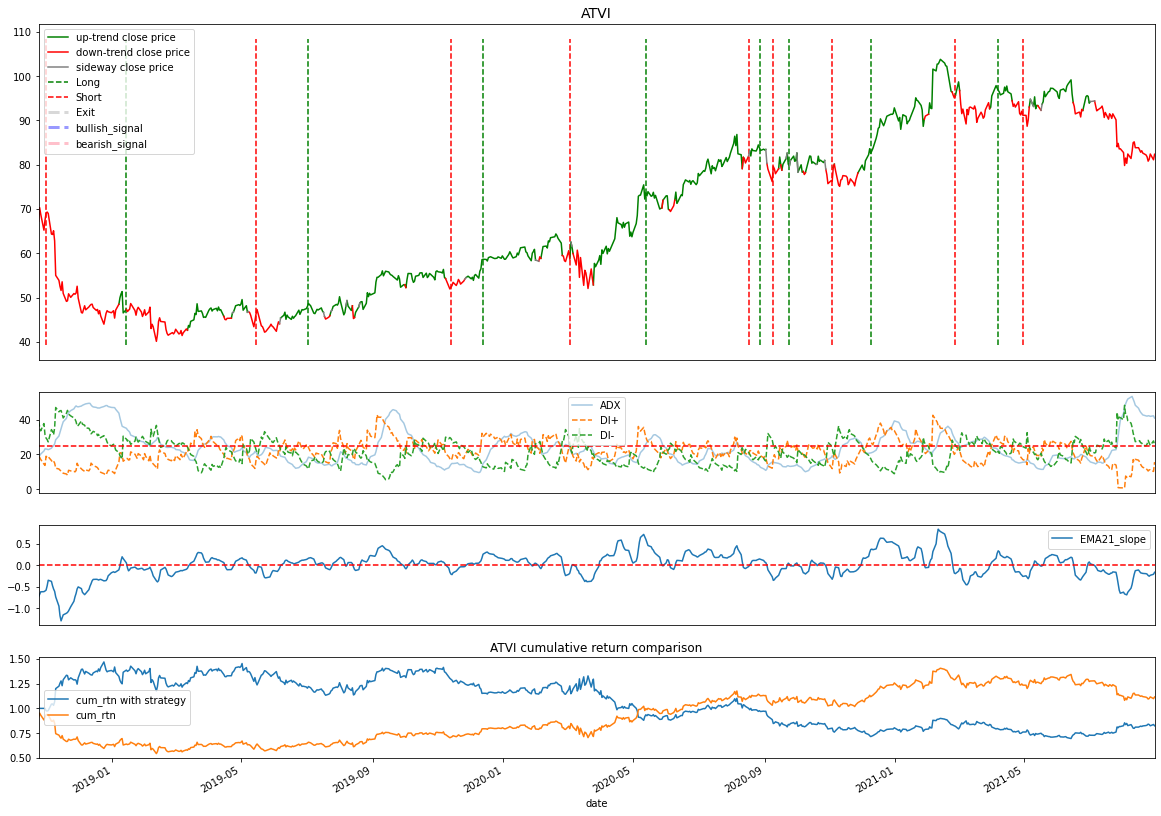

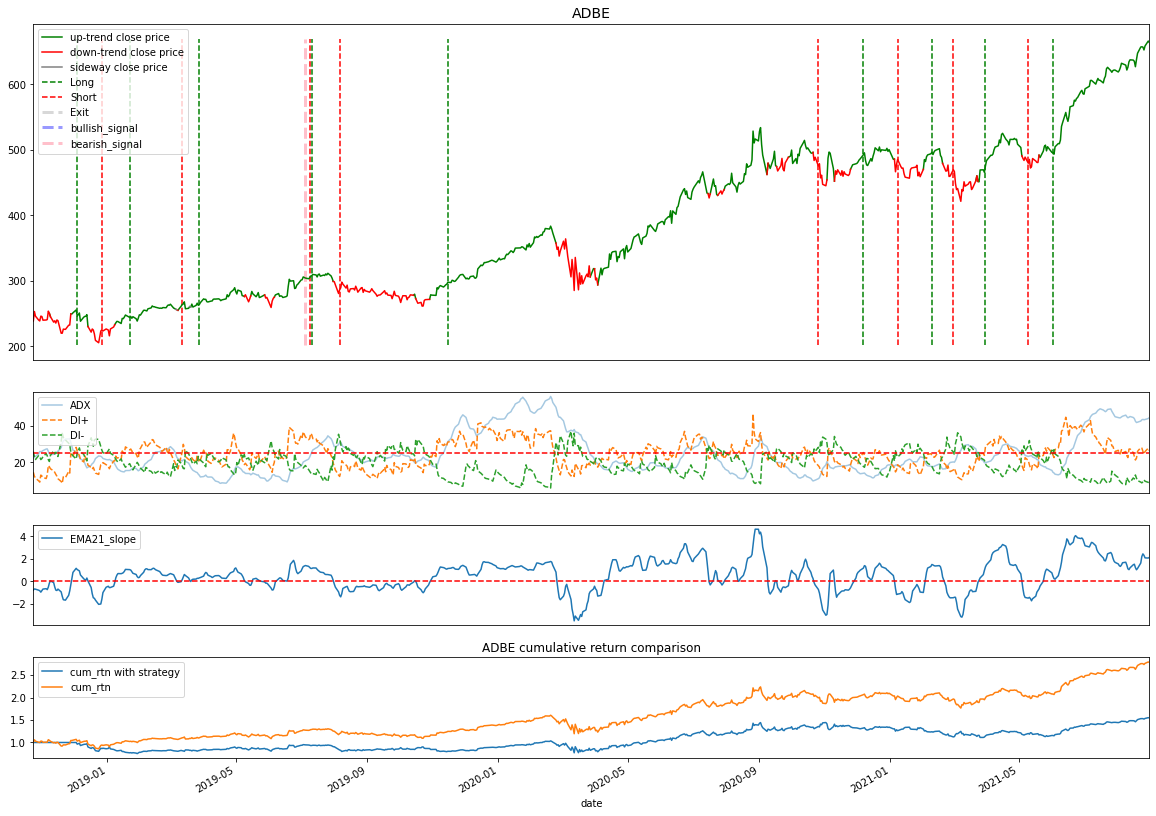

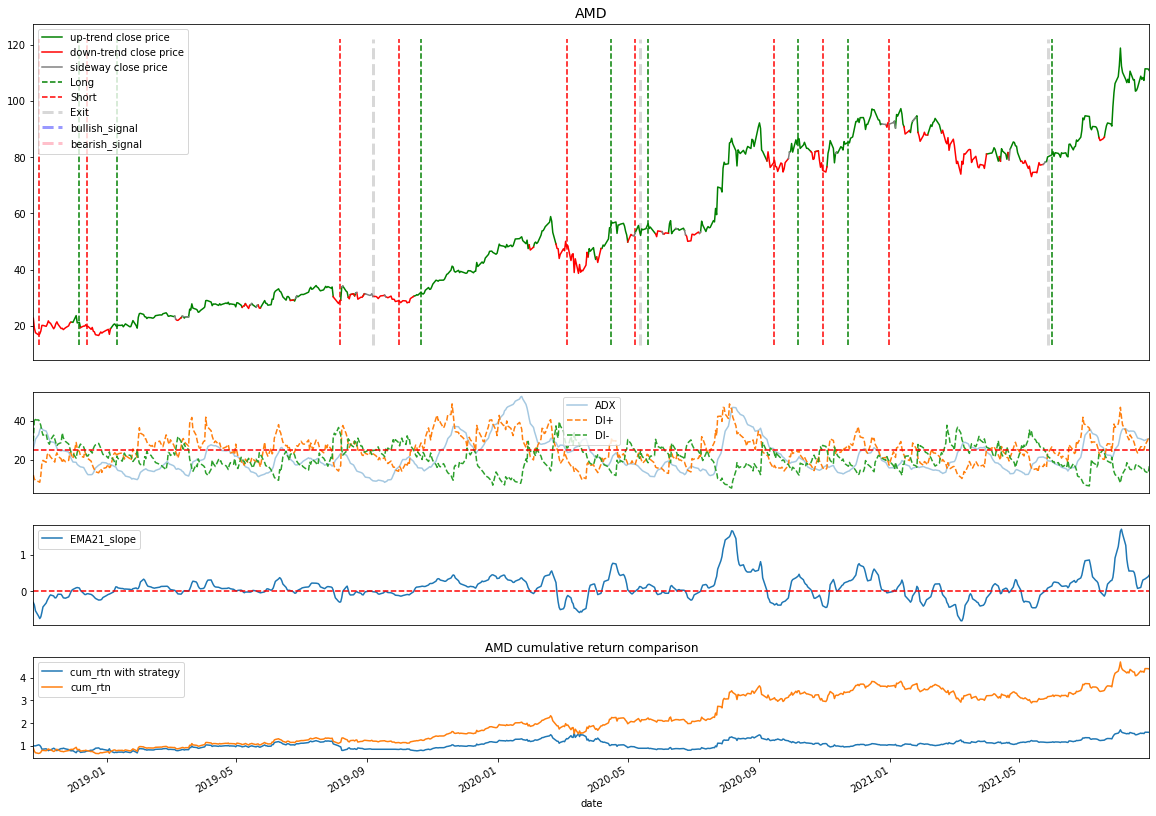

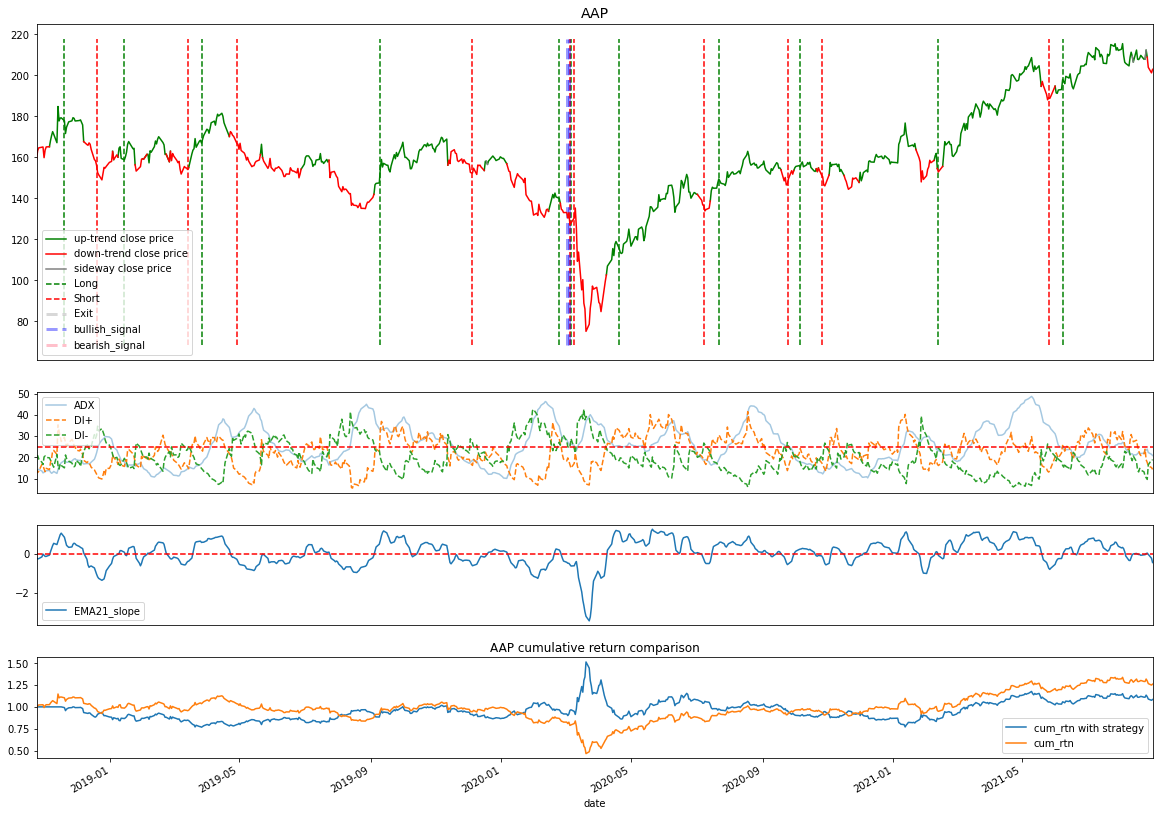

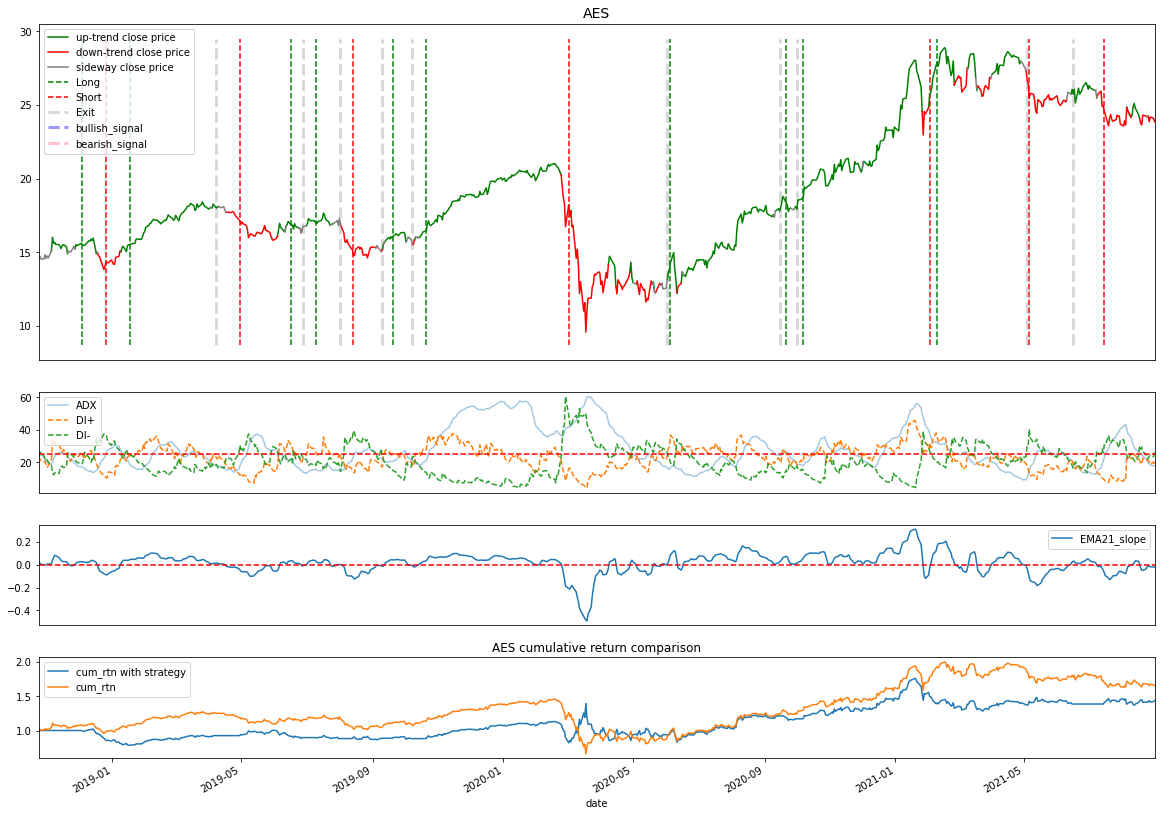

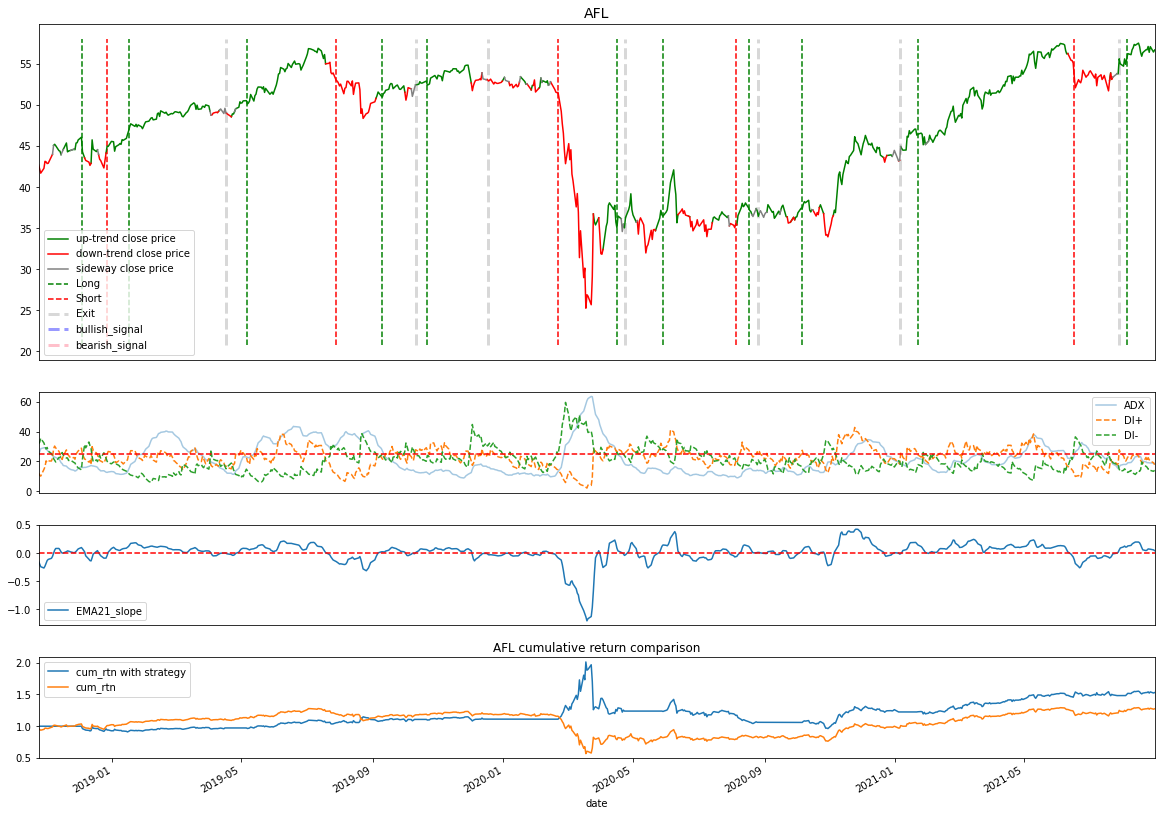

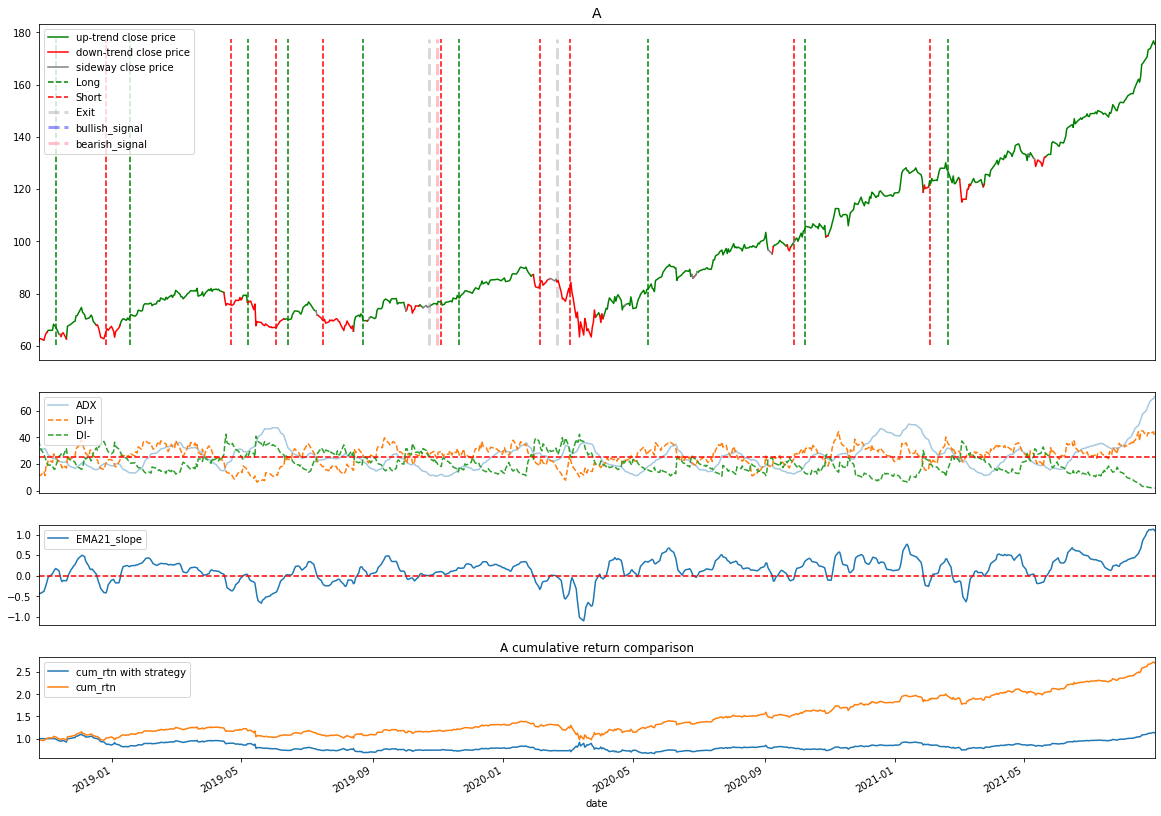

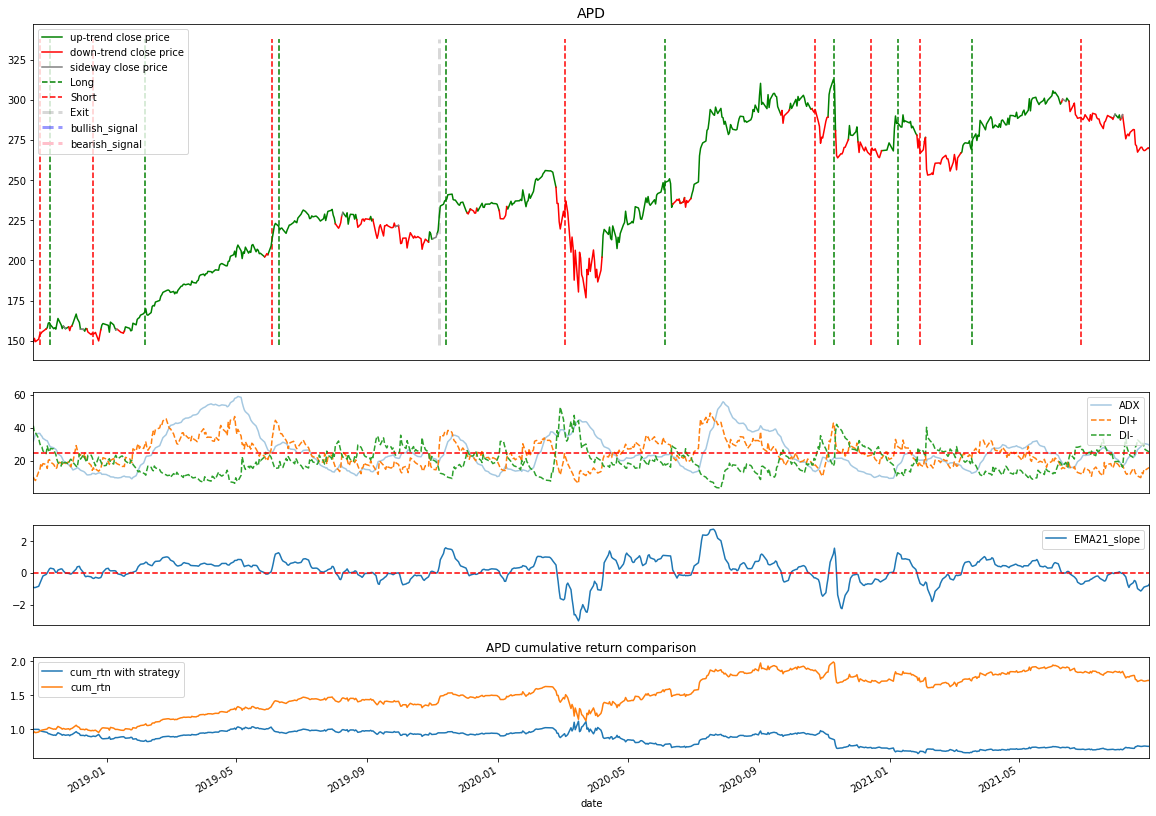

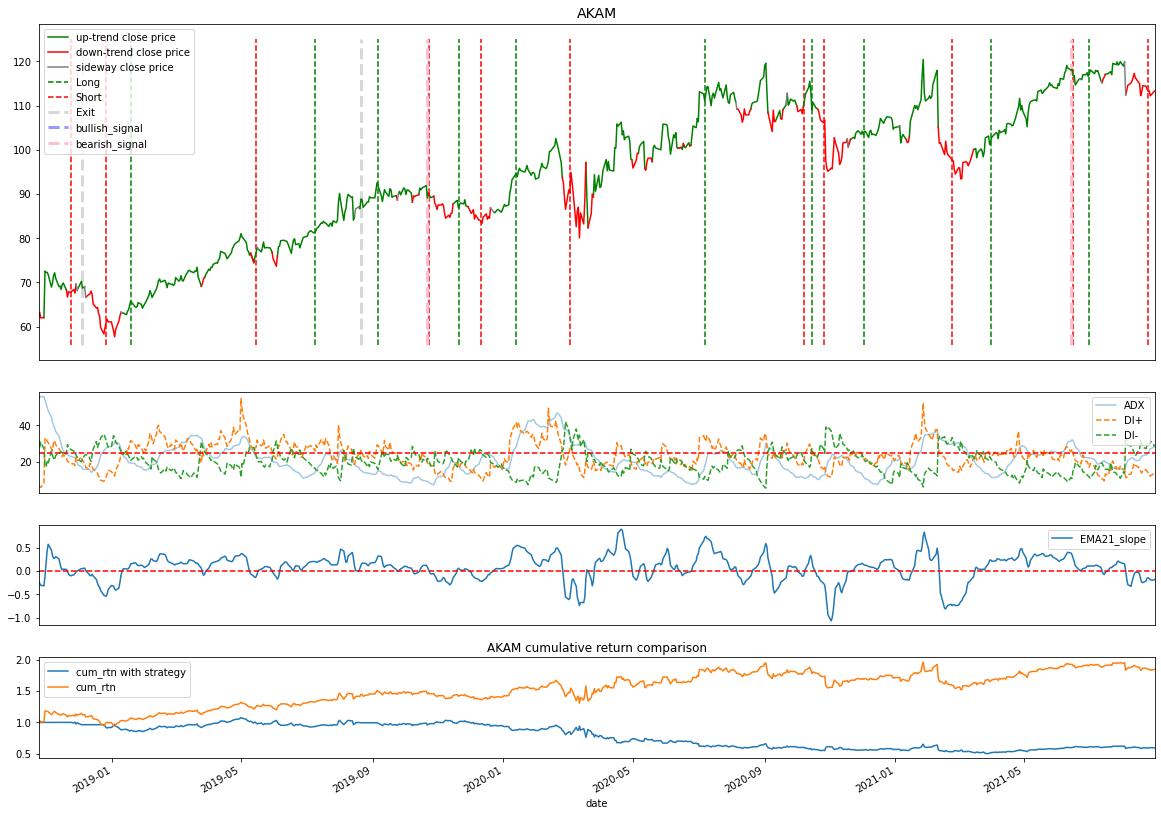

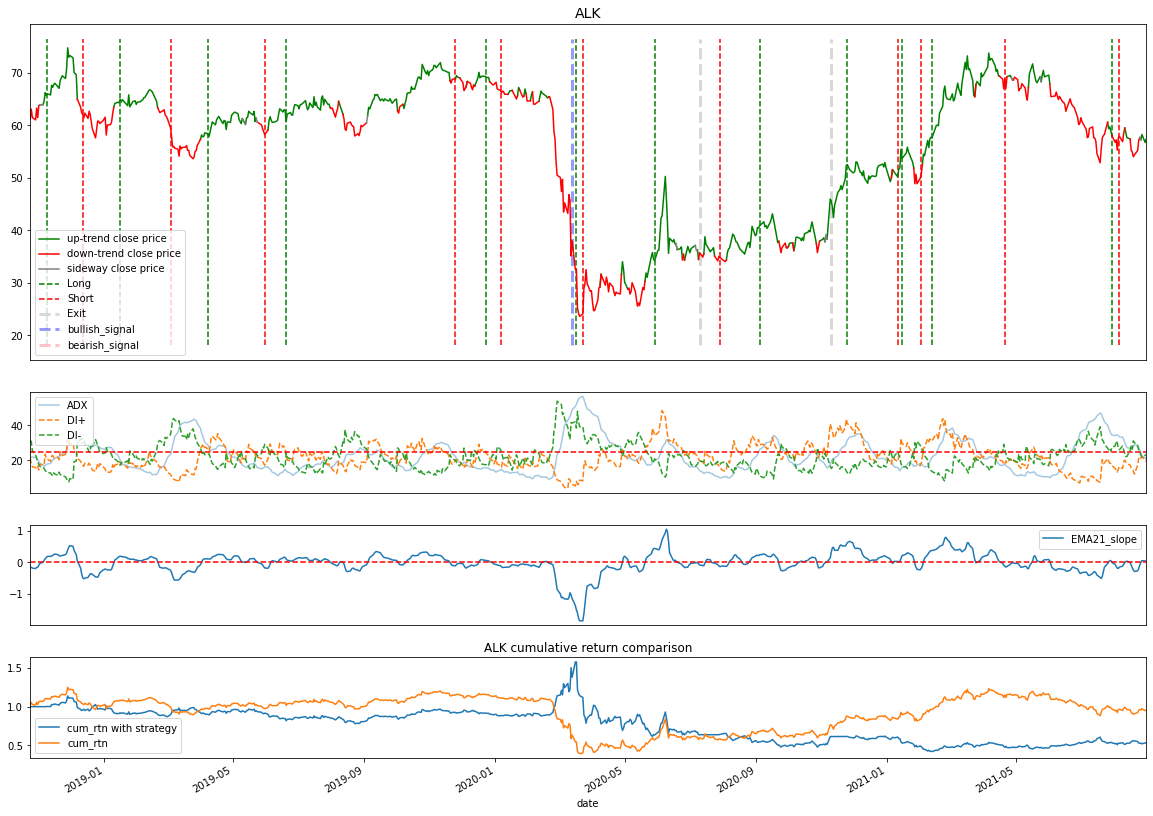

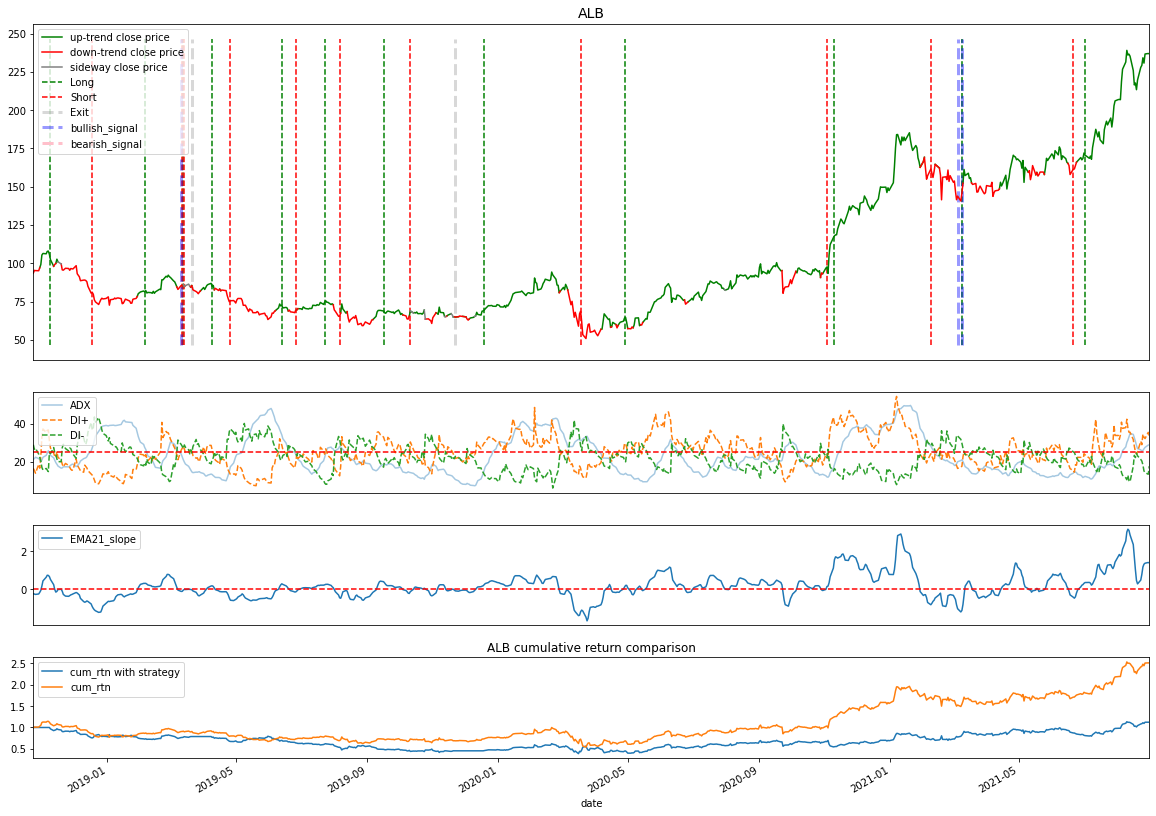

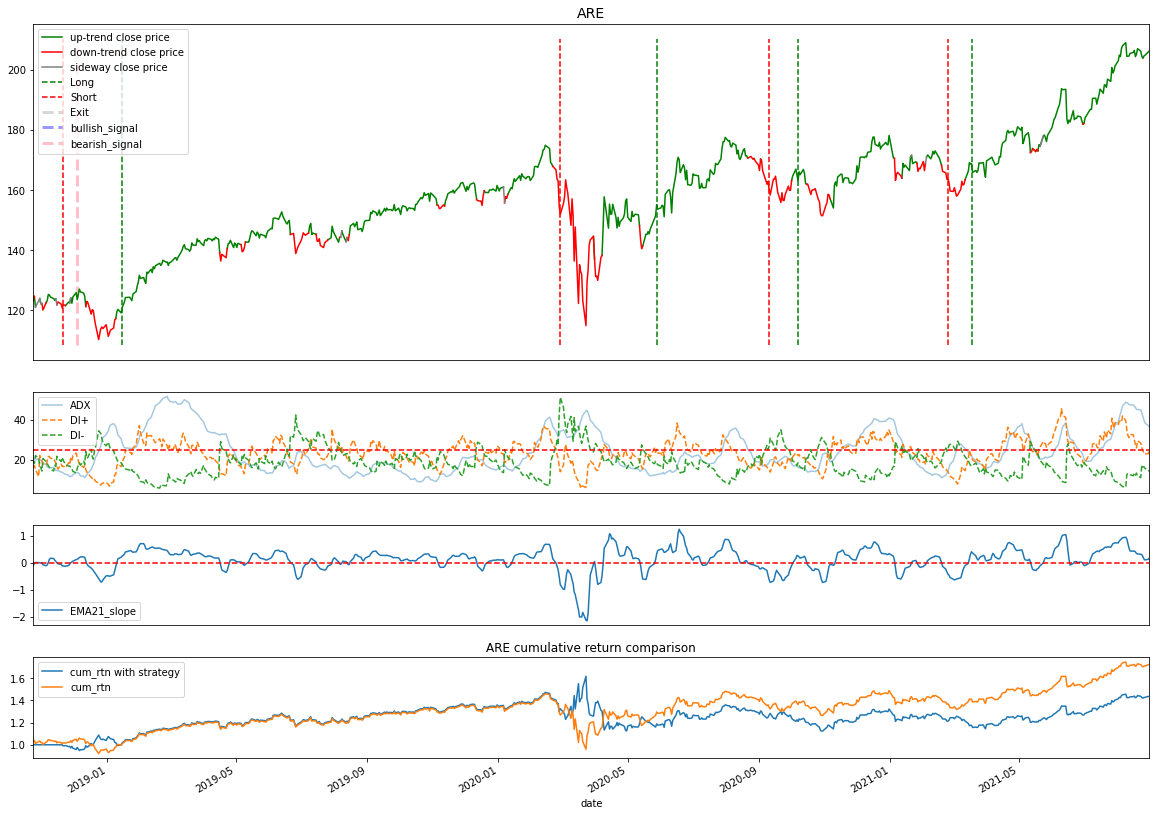

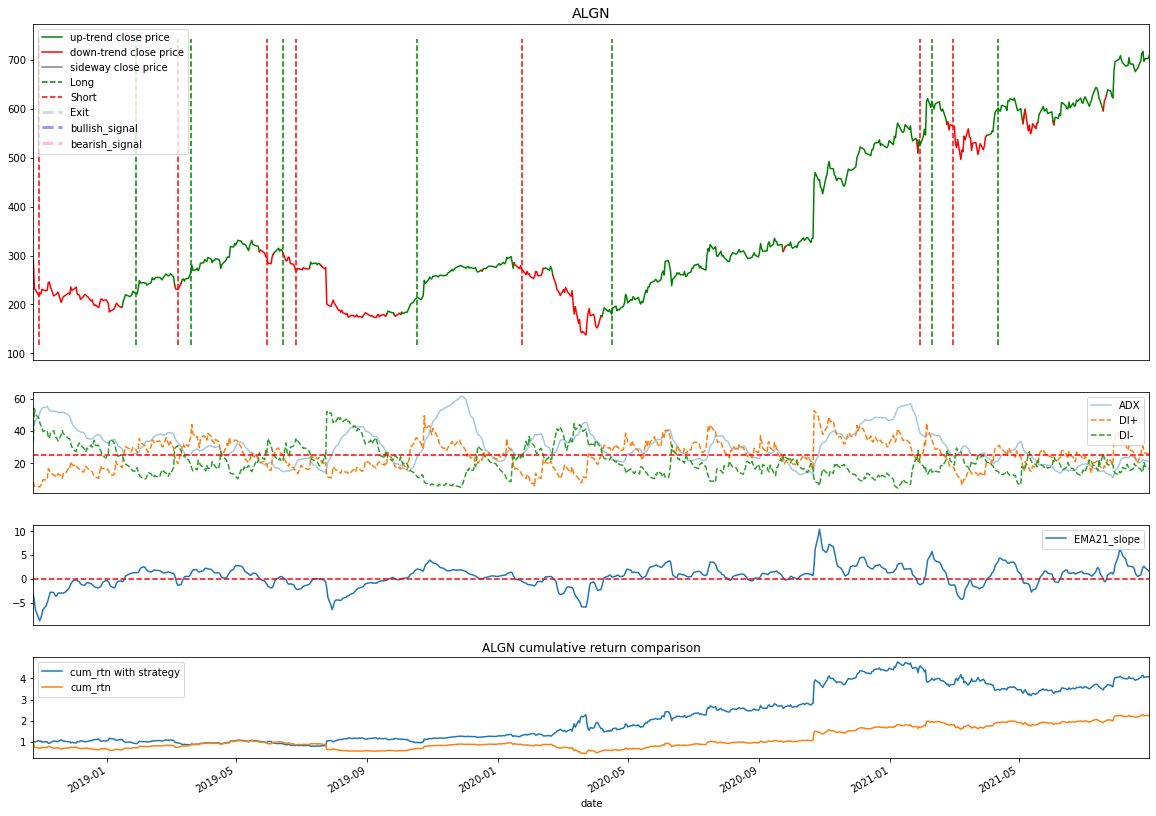

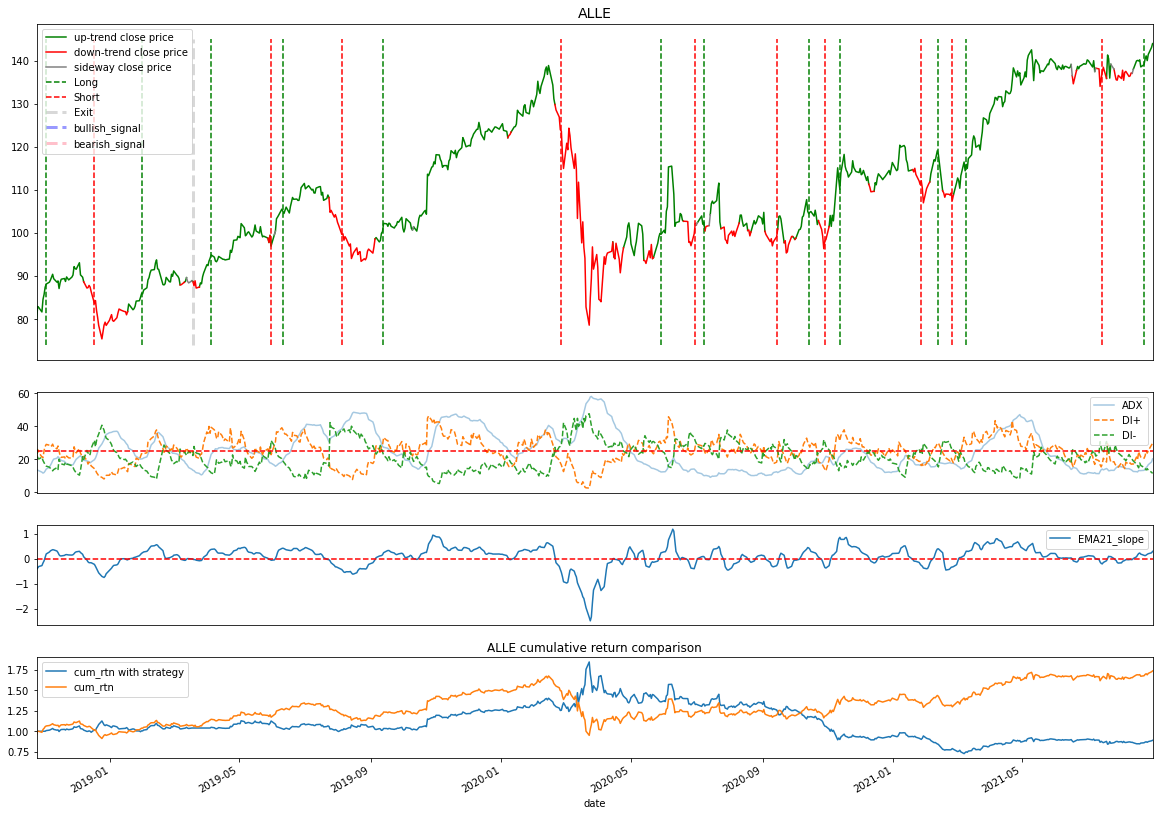

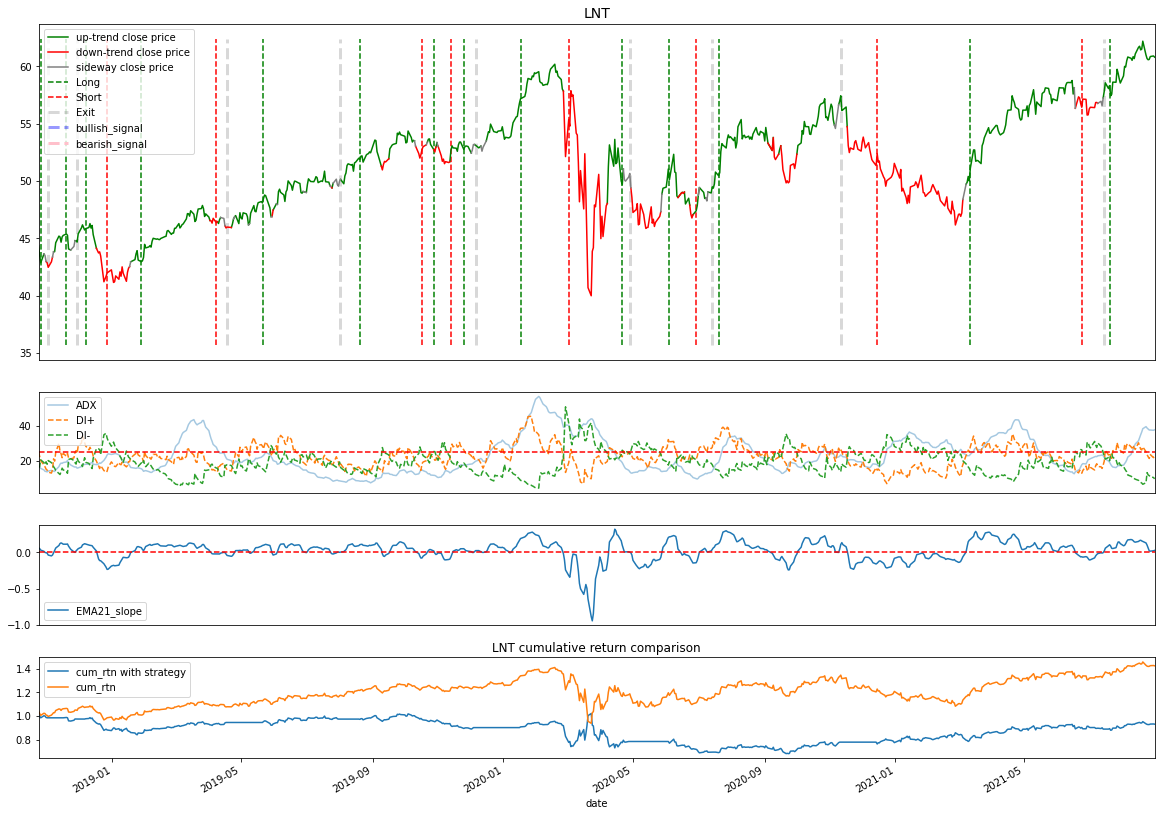

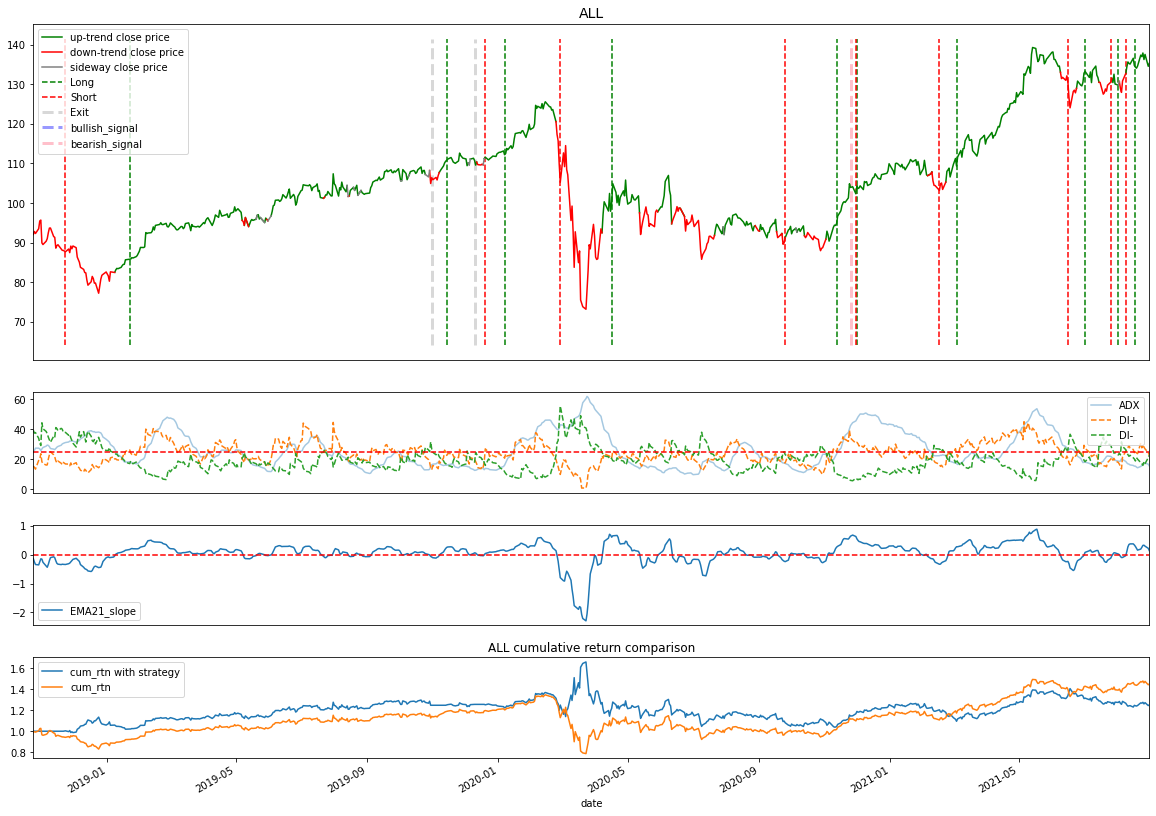

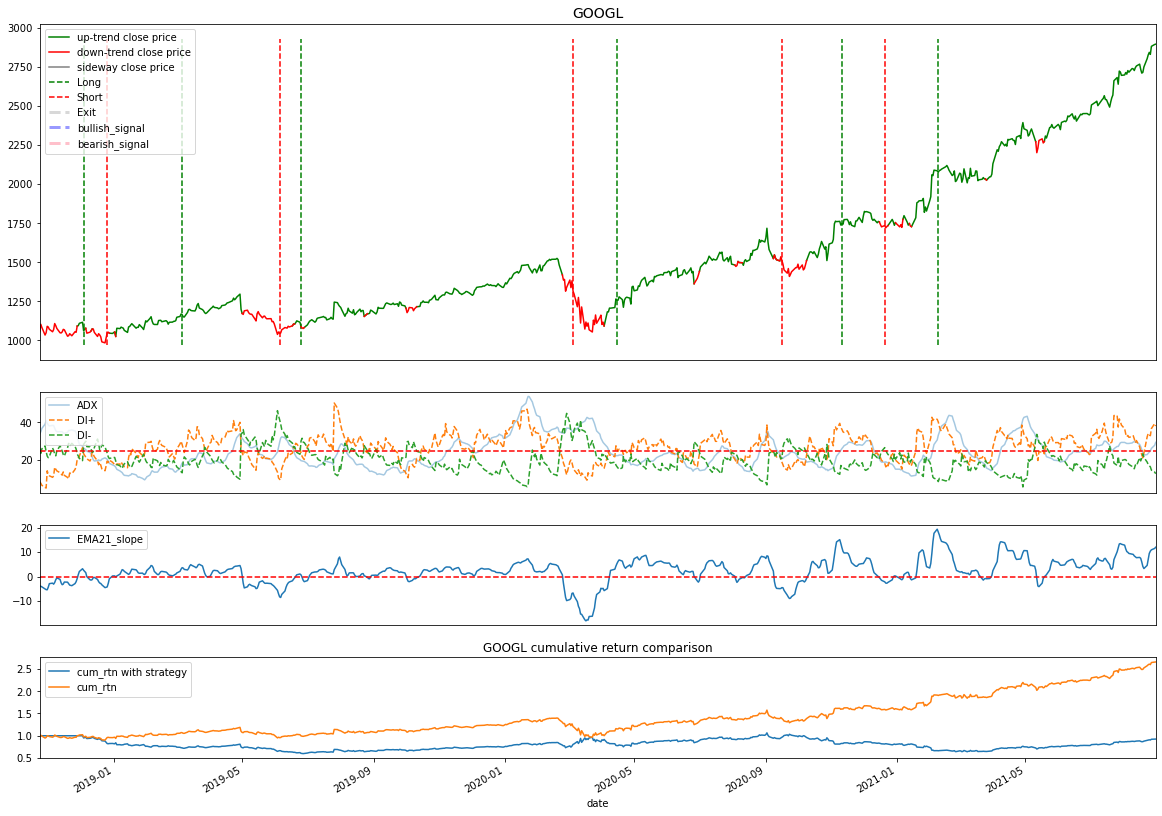

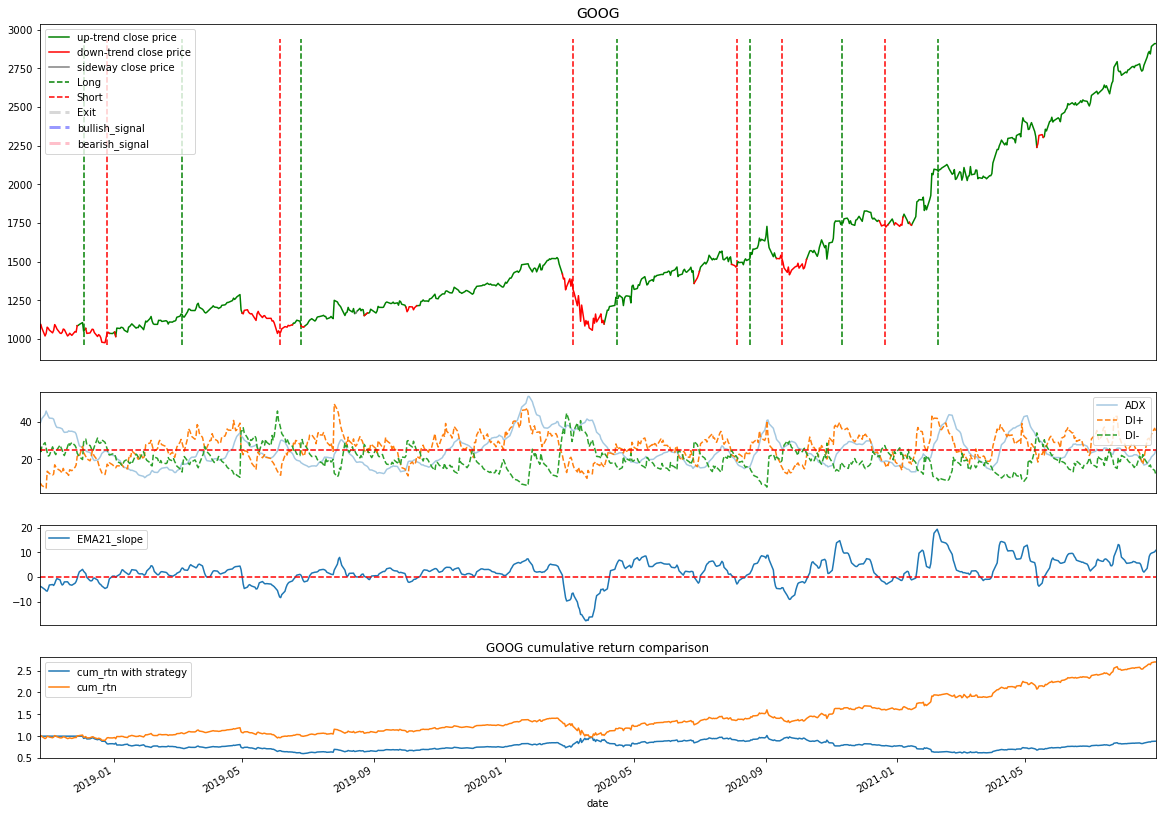

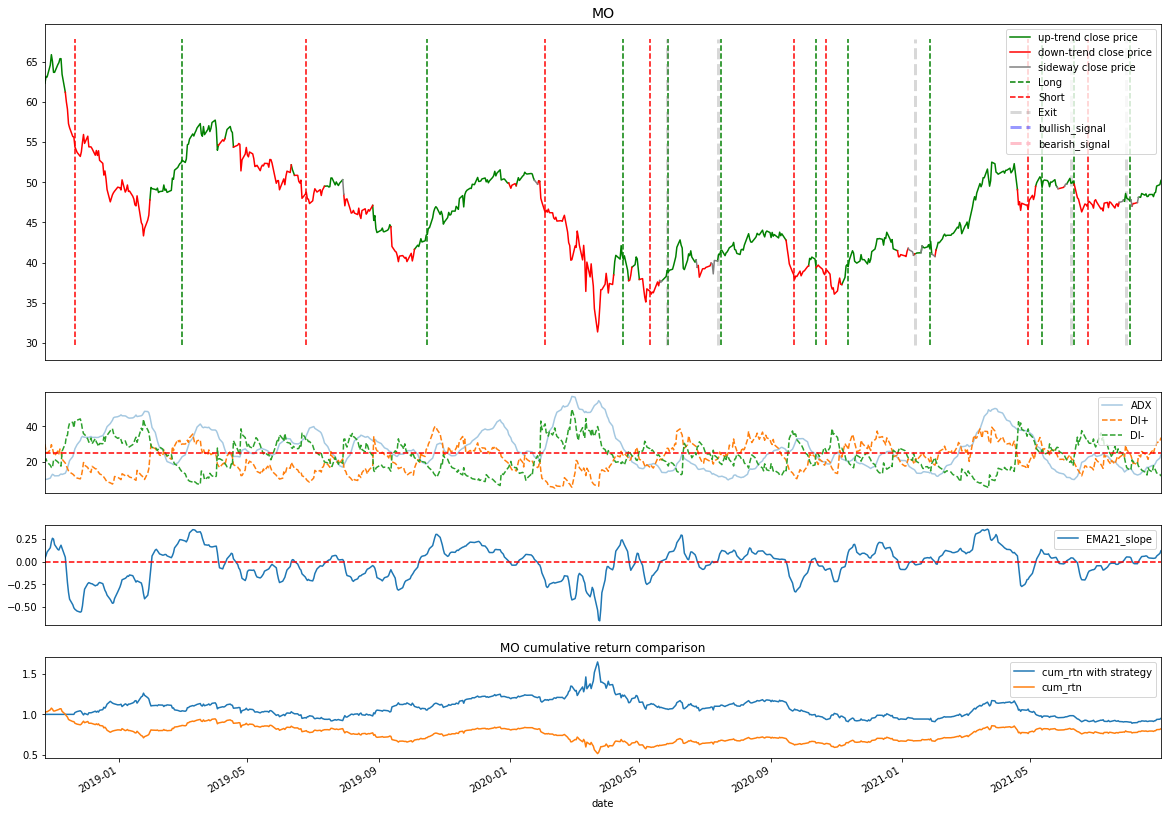

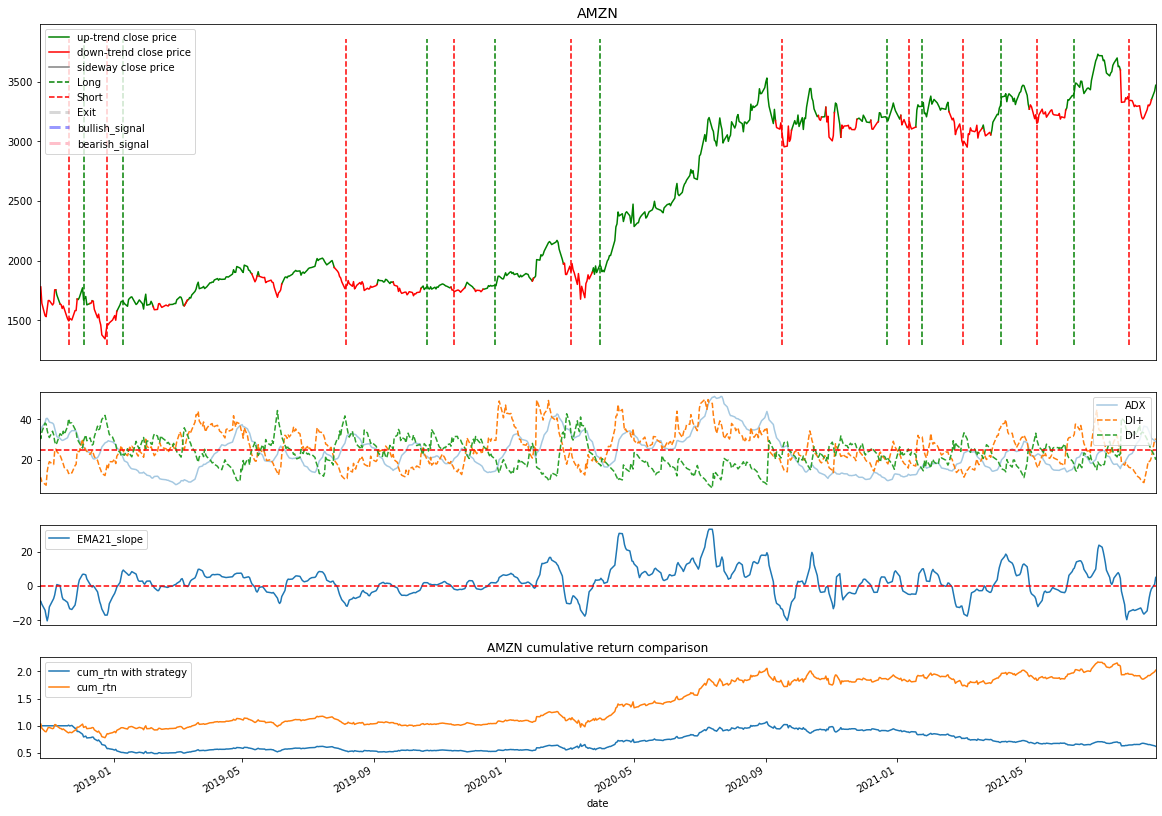

In [ ]:
tickers = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fm_key}').json()
tickers = pd.DataFrame(tickers)
tickers = tickers.loc[:,'symbol'].to_list()
# tickers

for ticker in tickers[0:30]:
    fibo_doji(ticker)